<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, flat_field step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and flat_field validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
import shutil
import os
from tempfile import TemporaryDirectory

use_tempdir = True
if use_tempdir:
    # Create temporary directory
    data_dir = TemporaryDirectory()
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /Users/pena/crds_cache


In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.pipeline.calwebb_spec2 import Spec2Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata



**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-031 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-055
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [4]:
# Print versions used for the pipeline and NPTT

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  1.1.22.dev0+gfd70d8d.d20211101


<a id="intro_ID"></a>
# Test Description

The test is a direct comparison of the result of our implementation of the flat field step algorithm versus the pipeline's implementation, i.e.: 
              difference =  absolute( Flat_nirspec_implementation - Flat_pipeline)

We expect the absolute difference to be of the order of 1x10^-6. We set this threshold by assuming that the difference should yield computer precision 1x10^-7 numbers. We then relaxed one order of magnitude due to interpolation differences in the algorithms.

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```flattest_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```flattest_ifu.py```.

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flatfield


### Test Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Flat+Field+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the flat_field step, use the command:

$ strun jwst.flat_field.FlatFieldStep jwtest_extract_2d.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.flat_field.flat_field_step import FlatFieldStep
 
$\gt$ FlatFieldStep.call(jwtest_extract_2d.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:
- output_directory = string, path where you want intermediary files and plots to be saved in, if writefile=True
- input_file = string or object, this is the output file from the previous step, e.g. jwtest1_NRS1_extract2d.fits
- dflat_path = string, path of where the D-flat reference fits files
- sflat_path = string, path of where the S-flat reference fits files
- fflat_path = string, path of where the F-flat reference fits files
- writefile = boolean, if True writes the fits files of the calculated flat, and the difference jpeg images
- save_figs = boolean, whether to save plots or not
- show_figs = boolean, whether to show plots or not 
- threshold_diff = float, threshold difference between pipeline output and ESA file


<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS_BOTS_G235H_F170LP


[Top of Page](#title_ID)

In [5]:
testing_data = {

                'bots_g235h_f170lp':{
                                  'uncal_file_nrs1': 'bots_g235h_f170lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'bots_g235h_f170lp_nrs2_uncal.fits',
                                  'sflat_nrs1': 'nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs1_f_01.01.fits',
                                  'sflat_nrs2': 'nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs2_f_01.01.fits',
                                  'fflat': 'nirspec_FS_fflat_F170LP_01.01.fits',
                                  'msa_shutter_config': None }

                }

               


In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'sflat_nrs1', 'fflat', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data
    

In [7]:
# set the D-flat path (used for all test data)
print('Getting D-Flats from Artifactory...')

dflat_nrs1 = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'nirspec_data', 
                         'nirspec_dflat_nrs1_f_01.03.fits')

dflat_nrs2 = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'nirspec_data', 
                         'nirspec_dflat_nrs2_f_01.03.fits')
print('Got D-flats')

# set NPTT switches for this test and other variables
writefile = False
save_figs = False
show_figs = True
results_dict = {}
detectors = ['nrs1', 'nrs2']


Getting D-Flats from Artifactory...
Got D-flats


Starting to run pipeline and test for mode:  bots_g235h_f170lp
Testing files for detector:  nrs1
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/bots_g235h_f170lp_nrs1_uncal.fits
Filter =  F170LP
Running the detector1 pipeline...


2022-09-23 15:00:51,482 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf
2022-09-23 15:00:51,662 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-09-23 15:00:51,664 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-09-23 15:00:51,666 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-09-23 15:00:51,667 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-09-23 15:00:51,669 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-09-23 15:00:51,670 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-09-23 15:00:51,672 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-09-23 15:00:51,673 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-09-23 15:00:51,675 - stpipe.Detector1

2022-09-23 15:00:53,351 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0024.fits'.
2022-09-23 15:00:53,352 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0006.fits'.
2022-09-23 15:00:53,353 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-09-23 15:00:53,353 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-09-23 15:00:53,354 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0010.fits'.
2022-09-23 15:00:53,354 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0077.fits'.
2022-09-23 15:00:53,355 - stpipe.Detector1Pipeline - INFO - Sta

2022-09-23 15:02:14,564 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).
2022-09-23 15:02:14,566 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz', 'dark_output': None}
2022-09-23 15:02:14,597 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0066.fits
2022-09-23 15:02:14,710 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3000, ngroups=3, nframes=1, groupgap=0
2022-09-23 15:02:14,711 - stpipe.Detector1Pipeline.dark_current 

2022-09-23 15:02:38,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:02:38,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57505 pixels with at least one CR from three groups.
2022-09-23 15:02:40,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:
2022-09-23 15:02:40,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:02:40,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:02:40,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10392 pixels with at least one CR from three groups.
2022-09-23 15:02:40,897 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:
2022-09-23 15:02:40,916 - stpipe.Detector1P

2022-09-23 15:02:51,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:02:51,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:02:51,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21934 pixels with at least one CR from three groups.
2022-09-23 15:02:52,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 26:
2022-09-23 15:02:52,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:02:52,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:02:52,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3637 pixels with at least one

2022-09-23 15:02:58,645 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:
2022-09-23 15:02:58,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:02:58,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:02:58,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.
2022-09-23 15:02:58,701 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:
2022-09-23 15:02:58,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:02:58,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:02:58,724 - stpipe.Detector1

2022-09-23 15:03:06,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.
2022-09-23 15:03:07,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 55:
2022-09-23 15:03:07,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:07,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:07,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3076 pixels with at least one CR from three groups.
2022-09-23 15:03:07,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 56:
2022-09-23 15:03:07,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:07,197 - stpipe.Detec

2022-09-23 15:03:10,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:10,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21959 pixels with at least one CR from three groups.
2022-09-23 15:03:11,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 70:
2022-09-23 15:03:11,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:11,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:11,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.
2022-09-23 15:03:11,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 71:
2022-09-23 15:03:11,213 - stpipe.Detector1Pip

2022-09-23 15:03:16,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:16,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.
2022-09-23 15:03:16,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 85:
2022-09-23 15:03:16,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:16,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:16,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 610 pixels with at least one CR from three groups.
2022-09-23 15:03:16,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 86:
2022-09-23 15:03:17,004 - stpipe.Detector1Pipel

2022-09-23 15:03:19,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:19,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49084 pixels with at least one CR from three groups.
2022-09-23 15:03:21,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 100:
2022-09-23 15:03:21,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:21,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:21,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29759 pixels with at least one CR from three groups.
2022-09-23 15:03:23,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 101:
2022-09-23 15:03:23,141 - stpipe.Detector

2022-09-23 15:03:24,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:24,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:24,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9897 pixels with at least one CR from three groups.
2022-09-23 15:03:24,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 115:
2022-09-23 15:03:24,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:24,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:24,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15043 pixels with at least on

2022-09-23 15:03:31,636 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 129:
2022-09-23 15:03:31,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:31,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:31,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6772 pixels with at least one CR from three groups.
2022-09-23 15:03:31,931 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 130:
2022-09-23 15:03:31,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:31,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:31,952 - stpipe.Detect

2022-09-23 15:03:35,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18871 pixels with at least one CR from three groups.
2022-09-23 15:03:36,293 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 144:
2022-09-23 15:03:36,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:36,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:36,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.
2022-09-23 15:03:36,347 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 145:
2022-09-23 15:03:36,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:36,367 - stpipe.De

2022-09-23 15:03:42,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:42,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.
2022-09-23 15:03:42,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 159:
2022-09-23 15:03:42,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:42,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:42,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 744 pixels with at least one CR from three groups.
2022-09-23 15:03:42,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 160:
2022-09-23 15:03:42,500 - stpipe.Detector1Pip

2022-09-23 15:03:50,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:50,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:50,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.
2022-09-23 15:03:50,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 174:
2022-09-23 15:03:50,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:50,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:50,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one C

2022-09-23 15:03:53,609 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 188:
2022-09-23 15:03:53,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:53,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:53,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.
2022-09-23 15:03:53,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 189:
2022-09-23 15:03:53,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:03:53,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:03:53,678 - stpipe.Detecto

2022-09-23 15:04:01,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.
2022-09-23 15:04:01,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 203:
2022-09-23 15:04:01,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:01,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:01,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.
2022-09-23 15:04:01,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 204:
2022-09-23 15:04:01,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:01,373 - stpipe.Dete

2022-09-23 15:04:11,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:11,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.
2022-09-23 15:04:11,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 218:
2022-09-23 15:04:11,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:11,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:11,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.
2022-09-23 15:04:11,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 219:
2022-09-23 15:04:11,848 - stpipe.Detector1Pip

2022-09-23 15:04:16,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:16,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:16,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2554 pixels with at least one CR from three groups.
2022-09-23 15:04:16,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 233:
2022-09-23 15:04:16,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:16,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:16,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39780 pixels with at least on

2022-09-23 15:04:29,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 247:
2022-09-23 15:04:29,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:29,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:29,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.
2022-09-23 15:04:29,222 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 248:
2022-09-23 15:04:29,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:29,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:29,243 - stpipe.Detecto

2022-09-23 15:04:42,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19452 pixels with at least one CR from three groups.
2022-09-23 15:04:42,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 262:
2022-09-23 15:04:42,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:42,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:42,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.
2022-09-23 15:04:42,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 263:
2022-09-23 15:04:42,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:42,974 - stpipe.De

2022-09-23 15:04:52,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:52,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.
2022-09-23 15:04:52,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 277:
2022-09-23 15:04:52,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:52,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:52,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39952 pixels with at least one CR from three groups.
2022-09-23 15:04:53,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 278:
2022-09-23 15:04:53,966 - stpipe.Detector1P

2022-09-23 15:04:57,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:57,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:57,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.
2022-09-23 15:04:57,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 292:
2022-09-23 15:04:57,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:04:57,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:04:57,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 646 pixels with at least one C

2022-09-23 15:05:05,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 306:
2022-09-23 15:05:05,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:05,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:05,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 551 pixels with at least one CR from three groups.
2022-09-23 15:05:05,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 307:
2022-09-23 15:05:05,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:05,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:05,451 - stpipe.Detecto

2022-09-23 15:05:18,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37220 pixels with at least one CR from three groups.
2022-09-23 15:05:19,712 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 321:
2022-09-23 15:05:19,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:19,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:19,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1724 pixels with at least one CR from three groups.
2022-09-23 15:05:19,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 322:
2022-09-23 15:05:19,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:19,834 - stpipe.D

2022-09-23 15:05:25,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:25,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1158 pixels with at least one CR from three groups.
2022-09-23 15:05:25,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 336:
2022-09-23 15:05:25,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:25,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:25,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.
2022-09-23 15:05:25,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 337:
2022-09-23 15:05:25,368 - stpipe.Detector1Pi

2022-09-23 15:05:30,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:30,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:30,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6534 pixels with at least one CR from three groups.
2022-09-23 15:05:31,083 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 351:
2022-09-23 15:05:31,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:31,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:31,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4939 pixels with at least one

2022-09-23 15:05:37,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 365:
2022-09-23 15:05:37,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:37,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:37,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.
2022-09-23 15:05:37,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 366:
2022-09-23 15:05:37,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:37,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:37,158 - stpipe.Detecto

2022-09-23 15:05:41,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from three groups.
2022-09-23 15:05:42,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 380:
2022-09-23 15:05:42,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:42,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:42,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 663 pixels with at least one CR from three groups.
2022-09-23 15:05:42,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 381:
2022-09-23 15:05:42,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:42,232 - stpipe.De

2022-09-23 15:05:43,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:43,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.
2022-09-23 15:05:43,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 395:
2022-09-23 15:05:43,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:43,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:43,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28421 pixels with at least one CR from three groups.
2022-09-23 15:05:44,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 396:
2022-09-23 15:05:44,514 - stpipe.Detector1P

2022-09-23 15:05:46,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:46,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:46,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47971 pixels with at least one CR from three groups.
2022-09-23 15:05:48,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 410:
2022-09-23 15:05:48,497 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:48,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:48,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one

2022-09-23 15:05:55,263 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 424:
2022-09-23 15:05:55,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:55,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:55,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1189 pixels with at least one CR from three groups.
2022-09-23 15:05:55,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 425:
2022-09-23 15:05:55,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:05:55,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:05:55,368 - stpipe.Detect

2022-09-23 15:06:07,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.
2022-09-23 15:06:07,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 439:
2022-09-23 15:06:08,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:08,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:08,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.
2022-09-23 15:06:08,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 440:
2022-09-23 15:06:08,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:08,083 - stpipe.Dete

2022-09-23 15:06:15,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:15,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.
2022-09-23 15:06:15,059 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 454:
2022-09-23 15:06:15,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:15,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:15,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6942 pixels with at least one CR from three groups.
2022-09-23 15:06:15,474 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 455:
2022-09-23 15:06:15,500 - stpipe.Detector1Pi

2022-09-23 15:06:27,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:27,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:27,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.
2022-09-23 15:06:28,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 469:
2022-09-23 15:06:28,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:28,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:28,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one C

2022-09-23 15:06:33,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 483:
2022-09-23 15:06:33,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:33,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:33,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1625 pixels with at least one CR from three groups.
2022-09-23 15:06:33,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 484:
2022-09-23 15:06:33,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:33,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:33,993 - stpipe.Detect

2022-09-23 15:06:36,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.
2022-09-23 15:06:36,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 498:
2022-09-23 15:06:36,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:36,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:36,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.
2022-09-23 15:06:36,298 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 499:
2022-09-23 15:06:36,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:36,327 - stpipe.Dete

2022-09-23 15:06:47,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:47,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.
2022-09-23 15:06:47,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 513:
2022-09-23 15:06:47,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:47,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:47,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2612 pixels with at least one CR from three groups.
2022-09-23 15:06:48,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 514:
2022-09-23 15:06:48,114 - stpipe.Detector1Pi

2022-09-23 15:06:59,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:59,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:59,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8232 pixels with at least one CR from three groups.
2022-09-23 15:06:59,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 528:
2022-09-23 15:06:59,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:06:59,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:06:59,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one 

2022-09-23 15:07:04,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 542:
2022-09-23 15:07:04,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:04,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:04,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.
2022-09-23 15:07:04,188 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 543:
2022-09-23 15:07:04,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:04,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:04,214 - stpipe.Detecto

2022-09-23 15:07:20,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6138 pixels with at least one CR from three groups.
2022-09-23 15:07:20,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 557:
2022-09-23 15:07:20,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:20,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:20,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4280 pixels with at least one CR from three groups.
2022-09-23 15:07:21,089 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 558:
2022-09-23 15:07:21,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:21,118 - stpipe.De

2022-09-23 15:07:35,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:35,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.
2022-09-23 15:07:35,331 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 572:
2022-09-23 15:07:35,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:35,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:35,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10188 pixels with at least one CR from three groups.
2022-09-23 15:07:35,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 573:
2022-09-23 15:07:35,846 - stpipe.Detector1P

2022-09-23 15:07:43,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:43,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:43,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3755 pixels with at least one CR from three groups.
2022-09-23 15:07:43,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 587:
2022-09-23 15:07:43,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:43,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:43,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one 

2022-09-23 15:07:58,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 601:
2022-09-23 15:07:58,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:58,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:58,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6506 pixels with at least one CR from three groups.
2022-09-23 15:07:59,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 602:
2022-09-23 15:07:59,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:07:59,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:07:59,076 - stpipe.Detect

2022-09-23 15:08:06,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 920 pixels with at least one CR from three groups.
2022-09-23 15:08:06,470 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 616:
2022-09-23 15:08:06,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:06,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:06,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38166 pixels with at least one CR from three groups.
2022-09-23 15:08:08,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 617:
2022-09-23 15:08:08,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:08,228 - stpipe.De

2022-09-23 15:08:12,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:12,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1334 pixels with at least one CR from three groups.
2022-09-23 15:08:12,291 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 631:
2022-09-23 15:08:12,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:12,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:12,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.
2022-09-23 15:08:12,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 632:
2022-09-23 15:08:12,389 - stpipe.Detector1Pi

2022-09-23 15:08:18,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:18,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:18,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9079 pixels with at least one CR from three groups.
2022-09-23 15:08:18,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 646:
2022-09-23 15:08:18,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:18,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:18,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3888 pixels with at least one

2022-09-23 15:08:31,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 660:
2022-09-23 15:08:31,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:31,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:31,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 630 pixels with at least one CR from three groups.
2022-09-23 15:08:31,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 661:
2022-09-23 15:08:31,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:31,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:31,872 - stpipe.Detecto

2022-09-23 15:08:40,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60740 pixels with at least one CR from three groups.
2022-09-23 15:08:45,434 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 675:
2022-09-23 15:08:45,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:45,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:45,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1568 pixels with at least one CR from three groups.
2022-09-23 15:08:45,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 676:
2022-09-23 15:08:45,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:45,589 - stpipe.D

2022-09-23 15:08:52,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:52,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 845 pixels with at least one CR from three groups.
2022-09-23 15:08:52,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 690:
2022-09-23 15:08:52,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:08:52,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:08:52,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 632 pixels with at least one CR from three groups.
2022-09-23 15:08:52,676 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 691:
2022-09-23 15:08:52,701 - stpipe.Detector1Pip

2022-09-23 15:09:01,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:01,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:01,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2691 pixels with at least one CR from three groups.
2022-09-23 15:09:01,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 705:
2022-09-23 15:09:01,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:01,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:01,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one 

2022-09-23 15:09:08,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 719:
2022-09-23 15:09:08,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:08,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:08,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.
2022-09-23 15:09:08,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 720:
2022-09-23 15:09:08,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:08,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:08,998 - stpipe.Detecto

2022-09-23 15:09:25,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.
2022-09-23 15:09:25,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 734:
2022-09-23 15:09:25,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:25,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:25,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48418 pixels with at least one CR from three groups.
2022-09-23 15:09:27,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 735:
2022-09-23 15:09:27,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:27,971 - stpipe.De

2022-09-23 15:09:36,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:36,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6404 pixels with at least one CR from three groups.
2022-09-23 15:09:36,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 749:
2022-09-23 15:09:36,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:36,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:36,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1959 pixels with at least one CR from three groups.
2022-09-23 15:09:36,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 750:
2022-09-23 15:09:36,898 - stpipe.Detector1P

2022-09-23 15:09:53,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:53,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:53,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4484 pixels with at least one CR from three groups.
2022-09-23 15:09:53,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 764:
2022-09-23 15:09:53,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:09:53,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:09:53,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2351 pixels with at least one

2022-09-23 15:10:05,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 778:
2022-09-23 15:10:05,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:05,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:05,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.
2022-09-23 15:10:06,070 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 779:
2022-09-23 15:10:06,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:06,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:06,105 - stpipe.Detecto

2022-09-23 15:10:20,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6278 pixels with at least one CR from three groups.
2022-09-23 15:10:20,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 793:
2022-09-23 15:10:20,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:20,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:20,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.
2022-09-23 15:10:20,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 794:
2022-09-23 15:10:20,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:20,600 - stpipe.Det

2022-09-23 15:10:33,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:33,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45541 pixels with at least one CR from three groups.
2022-09-23 15:10:35,754 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 808:
2022-09-23 15:10:35,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:35,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:35,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20488 pixels with at least one CR from three groups.
2022-09-23 15:10:36,712 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 809:
2022-09-23 15:10:36,736 - stpipe.Detector

2022-09-23 15:10:47,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:47,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:47,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41835 pixels with at least one CR from three groups.
2022-09-23 15:10:49,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 823:
2022-09-23 15:10:49,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:10:49,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:10:49,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55898 pixels with at least o

2022-09-23 15:11:00,073 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 837:
2022-09-23 15:11:00,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:00,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:00,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.
2022-09-23 15:11:00,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 838:
2022-09-23 15:11:00,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:00,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:00,162 - stpipe.Detecto

2022-09-23 15:11:10,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.
2022-09-23 15:11:10,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 852:
2022-09-23 15:11:10,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:10,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:10,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.
2022-09-23 15:11:10,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 853:
2022-09-23 15:11:10,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:10,933 - stpipe.Dete

2022-09-23 15:11:16,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:16,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.
2022-09-23 15:11:16,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 867:
2022-09-23 15:11:16,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:16,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:16,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.
2022-09-23 15:11:16,965 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 868:
2022-09-23 15:11:16,989 - stpipe.Detector1Pip

2022-09-23 15:11:33,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:33,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:33,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58270 pixels with at least one CR from three groups.
2022-09-23 15:11:36,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 882:
2022-09-23 15:11:36,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:36,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:36,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 736 pixels with at least one

2022-09-23 15:11:37,745 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 896:
2022-09-23 15:11:37,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:37,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:37,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.
2022-09-23 15:11:37,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 897:
2022-09-23 15:11:37,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:37,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:37,816 - stpipe.Detecto

2022-09-23 15:11:44,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3009 pixels with at least one CR from three groups.
2022-09-23 15:11:44,975 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 911:
2022-09-23 15:11:44,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:44,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:44,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51738 pixels with at least one CR from three groups.
2022-09-23 15:11:46,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 912:
2022-09-23 15:11:46,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:46,916 - stpipe.D

2022-09-23 15:11:53,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:53,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37665 pixels with at least one CR from three groups.
2022-09-23 15:11:54,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 926:
2022-09-23 15:11:55,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:11:55,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:11:55,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.
2022-09-23 15:11:55,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 927:
2022-09-23 15:11:55,075 - stpipe.Detector1P

2022-09-23 15:12:05,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:05,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:05,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57534 pixels with at least one CR from three groups.
2022-09-23 15:12:08,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 941:
2022-09-23 15:12:08,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:08,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:08,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one

2022-09-23 15:12:12,691 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 955:
2022-09-23 15:12:12,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:12,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:12,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1690 pixels with at least one CR from three groups.
2022-09-23 15:12:12,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 956:
2022-09-23 15:12:12,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:12,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:12,828 - stpipe.Detect

2022-09-23 15:12:23,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30370 pixels with at least one CR from three groups.
2022-09-23 15:12:24,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 970:
2022-09-23 15:12:24,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:24,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:24,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10210 pixels with at least one CR from three groups.
2022-09-23 15:12:24,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 971:
2022-09-23 15:12:24,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:24,726 - stpipe.

2022-09-23 15:12:29,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:29,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9586 pixels with at least one CR from three groups.
2022-09-23 15:12:30,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 985:
2022-09-23 15:12:30,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:30,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:30,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 829 pixels with at least one CR from three groups.
2022-09-23 15:12:30,336 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 986:
2022-09-23 15:12:30,356 - stpipe.Detector1Pi

2022-09-23 15:12:36,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:36,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:36,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.
2022-09-23 15:12:36,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1000:
2022-09-23 15:12:36,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:36,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:36,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13611 pixels with at least on

2022-09-23 15:12:44,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1014:
2022-09-23 15:12:44,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:44,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:44,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59845 pixels with at least one CR from three groups.
2022-09-23 15:12:48,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1015:
2022-09-23 15:12:48,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:48,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:48,222 - stpipe.Det

2022-09-23 15:12:55,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1790 pixels with at least one CR from three groups.
2022-09-23 15:12:55,607 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1029:
2022-09-23 15:12:55,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:55,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:12:55,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.
2022-09-23 15:12:55,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1030:
2022-09-23 15:12:55,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:12:55,690 - stpipe.D

2022-09-23 15:13:00,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:00,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4181 pixels with at least one CR from three groups.
2022-09-23 15:13:00,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1044:
2022-09-23 15:13:00,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:00,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:00,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2879 pixels with at least one CR from three groups.
2022-09-23 15:13:00,991 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1045:
2022-09-23 15:13:01,011 - stpipe.Detector

2022-09-23 15:13:03,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:03,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:03,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.
2022-09-23 15:13:03,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1059:
2022-09-23 15:13:03,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:03,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:03,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4953 pixels with at least one

2022-09-23 15:13:12,859 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1073:
2022-09-23 15:13:12,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:12,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:12,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18549 pixels with at least one CR from three groups.
2022-09-23 15:13:13,674 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1074:
2022-09-23 15:13:13,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:13,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:13,706 - stpipe.Det

2022-09-23 15:13:28,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.
2022-09-23 15:13:28,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1088:
2022-09-23 15:13:28,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:28,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:28,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.
2022-09-23 15:13:28,780 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1089:
2022-09-23 15:13:28,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:28,805 - stpipe.De

2022-09-23 15:13:35,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:35,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.
2022-09-23 15:13:35,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1103:
2022-09-23 15:13:35,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:35,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:35,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.
2022-09-23 15:13:35,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1104:
2022-09-23 15:13:35,606 - stpipe.Detector1P

2022-09-23 15:13:44,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:44,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:44,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.
2022-09-23 15:13:44,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1118:
2022-09-23 15:13:44,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:44,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:44,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1051 pixels with at least one

2022-09-23 15:13:50,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1132:
2022-09-23 15:13:50,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:50,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:50,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.
2022-09-23 15:13:50,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1133:
2022-09-23 15:13:50,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:13:50,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:13:50,302 - stpipe.Detec

2022-09-23 15:14:01,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.
2022-09-23 15:14:01,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1147:
2022-09-23 15:14:01,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:01,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:01,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1640 pixels with at least one CR from three groups.
2022-09-23 15:14:01,708 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1148:
2022-09-23 15:14:01,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:01,732 - stpipe.D

2022-09-23 15:14:09,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:09,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.
2022-09-23 15:14:09,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1162:
2022-09-23 15:14:09,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:09,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:09,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9350 pixels with at least one CR from three groups.
2022-09-23 15:14:10,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1163:
2022-09-23 15:14:10,288 - stpipe.Detector1

2022-09-23 15:14:16,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:16,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:16,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1565 pixels with at least one CR from three groups.
2022-09-23 15:14:16,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1177:
2022-09-23 15:14:16,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:16,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:16,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62193 pixels with at least o

2022-09-23 15:14:36,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1191:
2022-09-23 15:14:36,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:36,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:36,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 479 pixels with at least one CR from three groups.
2022-09-23 15:14:36,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1192:
2022-09-23 15:14:36,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:36,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:36,420 - stpipe.Detec

2022-09-23 15:14:43,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.
2022-09-23 15:14:43,751 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1206:
2022-09-23 15:14:43,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:43,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:43,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10857 pixels with at least one CR from three groups.
2022-09-23 15:14:44,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1207:
2022-09-23 15:14:44,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:44,207 - stpipe.

2022-09-23 15:14:50,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:50,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7500 pixels with at least one CR from three groups.
2022-09-23 15:14:50,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1221:
2022-09-23 15:14:50,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:50,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:50,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8626 pixels with at least one CR from three groups.
2022-09-23 15:14:51,229 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1222:
2022-09-23 15:14:51,253 - stpipe.Detector

2022-09-23 15:14:58,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:58,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:58,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 607 pixels with at least one CR from three groups.
2022-09-23 15:14:58,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1236:
2022-09-23 15:14:58,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:14:58,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:14:58,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one 

2022-09-23 15:15:07,106 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1250:
2022-09-23 15:15:07,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:07,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:07,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59022 pixels with at least one CR from three groups.
2022-09-23 15:15:10,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1251:
2022-09-23 15:15:10,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:10,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:10,087 - stpipe.Det

2022-09-23 15:15:12,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25004 pixels with at least one CR from three groups.
2022-09-23 15:15:13,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1265:
2022-09-23 15:15:13,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:13,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:13,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53549 pixels with at least one CR from three groups.
2022-09-23 15:15:15,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1266:
2022-09-23 15:15:15,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:15,333 - stpip

2022-09-23 15:15:24,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:24,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9046 pixels with at least one CR from three groups.
2022-09-23 15:15:24,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1280:
2022-09-23 15:15:24,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:24,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:24,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.
2022-09-23 15:15:24,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1281:
2022-09-23 15:15:24,682 - stpipe.Detector1

2022-09-23 15:15:28,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:28,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:28,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2355 pixels with at least one CR from three groups.
2022-09-23 15:15:28,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1295:
2022-09-23 15:15:28,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:28,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:28,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one

2022-09-23 15:15:34,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1309:
2022-09-23 15:15:34,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:34,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:34,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21017 pixels with at least one CR from three groups.
2022-09-23 15:15:35,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1310:
2022-09-23 15:15:35,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:35,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:35,623 - stpipe.Det

2022-09-23 15:15:48,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.
2022-09-23 15:15:48,989 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1324:
2022-09-23 15:15:49,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:49,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:15:49,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58442 pixels with at least one CR from three groups.
2022-09-23 15:15:53,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1325:
2022-09-23 15:15:53,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:15:53,139 - stpipe.

2022-09-23 15:16:01,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:01,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 796 pixels with at least one CR from three groups.
2022-09-23 15:16:01,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1339:
2022-09-23 15:16:01,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:01,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:01,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36588 pixels with at least one CR from three groups.
2022-09-23 15:16:02,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1340:
2022-09-23 15:16:02,989 - stpipe.Detector

2022-09-23 15:16:14,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:14,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:14,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.
2022-09-23 15:16:14,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1354:
2022-09-23 15:16:14,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:14,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:14,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2574 pixels with at least one

2022-09-23 15:16:19,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1368:
2022-09-23 15:16:19,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:19,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:19,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9398 pixels with at least one CR from three groups.
2022-09-23 15:16:19,877 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1369:
2022-09-23 15:16:19,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:19,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:19,901 - stpipe.Dete

2022-09-23 15:16:32,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3444 pixels with at least one CR from three groups.
2022-09-23 15:16:32,969 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1383:
2022-09-23 15:16:32,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:32,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:32,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2011 pixels with at least one CR from three groups.
2022-09-23 15:16:33,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1384:
2022-09-23 15:16:33,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:33,101 - stpipe.

2022-09-23 15:16:44,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:44,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13018 pixels with at least one CR from three groups.
2022-09-23 15:16:44,962 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1398:
2022-09-23 15:16:44,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:44,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:44,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2423 pixels with at least one CR from three groups.
2022-09-23 15:16:45,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1399:
2022-09-23 15:16:45,127 - stpipe.Detecto

2022-09-23 15:16:55,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:55,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:55,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9375 pixels with at least one CR from three groups.
2022-09-23 15:16:55,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1413:
2022-09-23 15:16:55,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:16:55,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:16:55,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 819 pixels with at least one

2022-09-23 15:17:05,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1427:
2022-09-23 15:17:05,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:05,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:05,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.
2022-09-23 15:17:05,110 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1428:
2022-09-23 15:17:05,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:05,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:05,132 - stpipe.Detec

2022-09-23 15:17:14,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.
2022-09-23 15:17:14,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1442:
2022-09-23 15:17:14,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:14,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:14,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.
2022-09-23 15:17:14,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1443:
2022-09-23 15:17:14,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:14,301 - stpipe.De

2022-09-23 15:17:20,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:20,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.
2022-09-23 15:17:20,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1457:
2022-09-23 15:17:20,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:20,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:20,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 601 pixels with at least one CR from three groups.
2022-09-23 15:17:20,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1458:
2022-09-23 15:17:20,507 - stpipe.Detector1P

2022-09-23 15:17:30,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:30,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:30,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2495 pixels with at least one CR from three groups.
2022-09-23 15:17:30,802 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1472:
2022-09-23 15:17:30,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:30,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:30,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8826 pixels with at least on

2022-09-23 15:17:41,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1486:
2022-09-23 15:17:41,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:41,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:41,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4355 pixels with at least one CR from three groups.
2022-09-23 15:17:41,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1487:
2022-09-23 15:17:41,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:41,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:41,625 - stpipe.Dete

2022-09-23 15:17:48,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.
2022-09-23 15:17:48,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1501:
2022-09-23 15:17:48,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:48,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:48,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 865 pixels with at least one CR from three groups.
2022-09-23 15:17:48,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1502:
2022-09-23 15:17:48,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:48,137 - stpipe.De

2022-09-23 15:17:52,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:52,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 767 pixels with at least one CR from three groups.
2022-09-23 15:17:52,050 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1516:
2022-09-23 15:17:52,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:17:52,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:17:52,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3830 pixels with at least one CR from three groups.
2022-09-23 15:17:52,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1517:
2022-09-23 15:17:52,241 - stpipe.Detector1

2022-09-23 15:18:02,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:02,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:02,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1116 pixels with at least one CR from three groups.
2022-09-23 15:18:03,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1531:
2022-09-23 15:18:03,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:03,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:03,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58575 pixels with at least o

2022-09-23 15:18:09,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1545:
2022-09-23 15:18:09,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:09,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:09,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53665 pixels with at least one CR from three groups.
2022-09-23 15:18:11,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1546:
2022-09-23 15:18:11,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:11,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:11,288 - stpipe.Det

2022-09-23 15:18:16,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44573 pixels with at least one CR from three groups.
2022-09-23 15:18:17,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1560:
2022-09-23 15:18:17,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:17,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:17,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1153 pixels with at least one CR from three groups.
2022-09-23 15:18:17,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1561:
2022-09-23 15:18:17,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:17,836 - stpipe

2022-09-23 15:18:23,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:23,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6757 pixels with at least one CR from three groups.
2022-09-23 15:18:24,101 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1575:
2022-09-23 15:18:24,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:24,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:24,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60467 pixels with at least one CR from three groups.
2022-09-23 15:18:26,973 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1576:
2022-09-23 15:18:26,996 - stpipe.Detecto

2022-09-23 15:18:35,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:35,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:35,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6577 pixels with at least one CR from three groups.
2022-09-23 15:18:35,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1590:
2022-09-23 15:18:35,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:35,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:35,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54648 pixels with at least o

2022-09-23 15:18:44,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1604:
2022-09-23 15:18:44,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:44,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:44,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.
2022-09-23 15:18:44,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1605:
2022-09-23 15:18:44,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:44,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:44,955 - stpipe.Detec

2022-09-23 15:18:50,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.
2022-09-23 15:18:50,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1619:
2022-09-23 15:18:50,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:50,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:18:50,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 738 pixels with at least one CR from three groups.
2022-09-23 15:18:50,823 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1620:
2022-09-23 15:18:50,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:18:50,846 - stpipe.De

2022-09-23 15:19:02,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:02,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.
2022-09-23 15:19:02,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1634:
2022-09-23 15:19:02,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:02,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:02,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50260 pixels with at least one CR from three groups.
2022-09-23 15:19:04,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1635:
2022-09-23 15:19:04,074 - stpipe.Detector

2022-09-23 15:19:15,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:15,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:15,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.
2022-09-23 15:19:15,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1649:
2022-09-23 15:19:15,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:15,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:15,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52410 pixels with at least on

2022-09-23 15:19:25,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1663:
2022-09-23 15:19:25,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:25,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:25,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.
2022-09-23 15:19:25,296 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1664:
2022-09-23 15:19:25,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:25,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:25,318 - stpipe.Detec

2022-09-23 15:19:33,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 650 pixels with at least one CR from three groups.
2022-09-23 15:19:33,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1678:
2022-09-23 15:19:33,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:33,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:33,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.
2022-09-23 15:19:33,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1679:
2022-09-23 15:19:33,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:33,756 - stpipe.De

2022-09-23 15:19:41,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:41,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31278 pixels with at least one CR from three groups.
2022-09-23 15:19:42,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1693:
2022-09-23 15:19:42,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:42,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:42,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 574 pixels with at least one CR from three groups.
2022-09-23 15:19:42,557 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1694:
2022-09-23 15:19:42,581 - stpipe.Detector

2022-09-23 15:19:53,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:53,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:53,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6023 pixels with at least one CR from three groups.
2022-09-23 15:19:53,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1708:
2022-09-23 15:19:53,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:53,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:53,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3987 pixels with at least on

2022-09-23 15:19:58,207 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1722:
2022-09-23 15:19:58,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:58,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:58,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1534 pixels with at least one CR from three groups.
2022-09-23 15:19:58,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1723:
2022-09-23 15:19:58,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:19:58,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:19:58,332 - stpipe.Dete

2022-09-23 15:20:02,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.
2022-09-23 15:20:02,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1737:
2022-09-23 15:20:02,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:02,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:02,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 588 pixels with at least one CR from three groups.
2022-09-23 15:20:02,925 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1738:
2022-09-23 15:20:02,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:02,956 - stpipe.De

2022-09-23 15:20:11,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:11,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39178 pixels with at least one CR from three groups.
2022-09-23 15:20:13,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1752:
2022-09-23 15:20:13,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:13,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:13,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5592 pixels with at least one CR from three groups.
2022-09-23 15:20:14,111 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1753:
2022-09-23 15:20:14,141 - stpipe.Detecto

2022-09-23 15:20:32,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:32,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:32,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.
2022-09-23 15:20:32,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1767:
2022-09-23 15:20:32,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:32,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:32,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one 

2022-09-23 15:20:40,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1781:
2022-09-23 15:20:40,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:40,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:40,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2127 pixels with at least one CR from three groups.
2022-09-23 15:20:40,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1782:
2022-09-23 15:20:40,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:40,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:40,421 - stpipe.Dete

2022-09-23 15:20:47,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.
2022-09-23 15:20:47,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1796:
2022-09-23 15:20:47,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:47,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:47,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.
2022-09-23 15:20:47,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1797:
2022-09-23 15:20:47,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:47,654 - stpipe.De

2022-09-23 15:20:55,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:55,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.
2022-09-23 15:20:55,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1811:
2022-09-23 15:20:55,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:20:55,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:20:55,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.
2022-09-23 15:20:55,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1812:
2022-09-23 15:20:55,726 - stpipe.Detector1P

2022-09-23 15:21:02,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:02,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:02,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11796 pixels with at least one CR from three groups.
2022-09-23 15:21:02,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1826:
2022-09-23 15:21:02,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:02,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:02,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3356 pixels with at least o

2022-09-23 15:21:19,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1840:
2022-09-23 15:21:19,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:19,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:19,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1332 pixels with at least one CR from three groups.
2022-09-23 15:21:19,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1841:
2022-09-23 15:21:19,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:19,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:19,707 - stpipe.Dete

2022-09-23 15:21:26,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19412 pixels with at least one CR from three groups.
2022-09-23 15:21:27,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1855:
2022-09-23 15:21:27,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:27,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:27,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60679 pixels with at least one CR from three groups.
2022-09-23 15:21:30,961 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1856:
2022-09-23 15:21:30,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:30,986 - stpip

2022-09-23 15:21:41,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:41,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.
2022-09-23 15:21:41,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1870:
2022-09-23 15:21:41,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:41,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:41,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20598 pixels with at least one CR from three groups.
2022-09-23 15:21:42,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1871:
2022-09-23 15:21:42,323 - stpipe.Detector

2022-09-23 15:21:50,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:50,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:50,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.
2022-09-23 15:21:50,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1885:
2022-09-23 15:21:50,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:21:50,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:21:50,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57005 pixels with at least on

2022-09-23 15:22:07,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1899:
2022-09-23 15:22:07,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:07,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:07,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22926 pixels with at least one CR from three groups.
2022-09-23 15:22:08,965 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1900:
2022-09-23 15:22:08,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:08,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:08,991 - stpipe.Det

2022-09-23 15:22:16,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11949 pixels with at least one CR from three groups.
2022-09-23 15:22:16,625 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1914:
2022-09-23 15:22:16,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:16,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:16,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.
2022-09-23 15:22:16,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1915:
2022-09-23 15:22:16,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:16,728 - stpipe.

2022-09-23 15:22:29,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:29,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.
2022-09-23 15:22:29,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1929:
2022-09-23 15:22:29,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:29,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:29,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 827 pixels with at least one CR from three groups.
2022-09-23 15:22:29,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1930:
2022-09-23 15:22:29,298 - stpipe.Detector1P

2022-09-23 15:22:34,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:34,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:34,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1124 pixels with at least one CR from three groups.
2022-09-23 15:22:34,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1944:
2022-09-23 15:22:34,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:34,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:34,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37297 pixels with at least o

2022-09-23 15:22:44,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1958:
2022-09-23 15:22:44,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:44,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:44,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1168 pixels with at least one CR from three groups.
2022-09-23 15:22:44,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1959:
2022-09-23 15:22:44,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:44,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:44,608 - stpipe.Dete

2022-09-23 15:22:49,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8625 pixels with at least one CR from three groups.
2022-09-23 15:22:49,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1973:
2022-09-23 15:22:49,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:49,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:22:49,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1002 pixels with at least one CR from three groups.
2022-09-23 15:22:49,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1974:
2022-09-23 15:22:49,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:22:49,740 - stpipe.

2022-09-23 15:23:04,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:04,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2270 pixels with at least one CR from three groups.
2022-09-23 15:23:04,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1988:
2022-09-23 15:23:04,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:04,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:04,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 880 pixels with at least one CR from three groups.
2022-09-23 15:23:04,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1989:
2022-09-23 15:23:04,473 - stpipe.Detector1

2022-09-23 15:23:13,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:13,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:13,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.
2022-09-23 15:23:13,307 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2003:
2022-09-23 15:23:13,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:13,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:13,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12032 pixels with at least on

2022-09-23 15:23:21,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2017:
2022-09-23 15:23:21,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:21,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:21,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 940 pixels with at least one CR from three groups.
2022-09-23 15:23:21,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2018:
2022-09-23 15:23:21,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:21,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:21,763 - stpipe.Detec

2022-09-23 15:23:36,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.
2022-09-23 15:23:36,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2032:
2022-09-23 15:23:36,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:36,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:36,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 708 pixels with at least one CR from three groups.
2022-09-23 15:23:36,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2033:
2022-09-23 15:23:36,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:36,587 - stpipe.De

2022-09-23 15:23:47,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:47,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1201 pixels with at least one CR from three groups.
2022-09-23 15:23:47,118 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2047:
2022-09-23 15:23:47,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:47,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:47,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1027 pixels with at least one CR from three groups.
2022-09-23 15:23:47,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2048:
2022-09-23 15:23:47,237 - stpipe.Detector

2022-09-23 15:23:54,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:54,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:54,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2433 pixels with at least one CR from three groups.
2022-09-23 15:23:54,312 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2062:
2022-09-23 15:23:54,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:23:54,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:23:54,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4039 pixels with at least on

2022-09-23 15:24:04,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2076:
2022-09-23 15:24:04,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:04,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:04,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.
2022-09-23 15:24:04,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2077:
2022-09-23 15:24:04,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:04,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:04,694 - stpipe.Detec

2022-09-23 15:24:12,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1375 pixels with at least one CR from three groups.
2022-09-23 15:24:13,078 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2091:
2022-09-23 15:24:13,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:13,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:13,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.
2022-09-23 15:24:13,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2092:
2022-09-23 15:24:13,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:13,172 - stpipe.D

2022-09-23 15:24:19,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:19,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 920 pixels with at least one CR from three groups.
2022-09-23 15:24:19,624 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2106:
2022-09-23 15:24:19,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:19,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:19,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.
2022-09-23 15:24:19,699 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2107:
2022-09-23 15:24:19,725 - stpipe.Detector1P

2022-09-23 15:24:28,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:28,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:28,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 789 pixels with at least one CR from three groups.
2022-09-23 15:24:28,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2121:
2022-09-23 15:24:28,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:28,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:28,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1446 pixels with at least one

2022-09-23 15:24:40,275 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2135:
2022-09-23 15:24:40,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:40,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:40,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21314 pixels with at least one CR from three groups.
2022-09-23 15:24:41,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2136:
2022-09-23 15:24:41,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:41,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:41,273 - stpipe.Det

2022-09-23 15:24:47,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.
2022-09-23 15:24:47,719 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2150:
2022-09-23 15:24:47,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:47,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:47,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 648 pixels with at least one CR from three groups.
2022-09-23 15:24:47,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2151:
2022-09-23 15:24:47,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:47,822 - stpipe.De

2022-09-23 15:24:54,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:54,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 751 pixels with at least one CR from three groups.
2022-09-23 15:24:54,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2165:
2022-09-23 15:24:54,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:24:54,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:24:54,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19026 pixels with at least one CR from three groups.
2022-09-23 15:24:55,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2166:
2022-09-23 15:24:55,491 - stpipe.Detector

2022-09-23 15:25:06,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:06,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:06,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56723 pixels with at least one CR from three groups.
2022-09-23 15:25:09,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2180:
2022-09-23 15:25:09,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:09,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:09,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2091 pixels with at least o

2022-09-23 15:25:18,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2194:
2022-09-23 15:25:18,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:18,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:18,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55547 pixels with at least one CR from three groups.
2022-09-23 15:25:21,000 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2195:
2022-09-23 15:25:21,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:21,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:21,026 - stpipe.Det

2022-09-23 15:25:32,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7427 pixels with at least one CR from three groups.
2022-09-23 15:25:32,663 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2209:
2022-09-23 15:25:32,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:32,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:32,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1879 pixels with at least one CR from three groups.
2022-09-23 15:25:32,789 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2210:
2022-09-23 15:25:32,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:32,814 - stpipe.

2022-09-23 15:25:42,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:42,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.
2022-09-23 15:25:42,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2224:
2022-09-23 15:25:42,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:42,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:42,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13019 pixels with at least one CR from three groups.
2022-09-23 15:25:43,083 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2225:
2022-09-23 15:25:43,109 - stpipe.Detector

2022-09-23 15:25:48,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:48,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:48,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 626 pixels with at least one CR from three groups.
2022-09-23 15:25:48,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2239:
2022-09-23 15:25:48,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:25:48,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:25:48,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57933 pixels with at least on

2022-09-23 15:26:00,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2253:
2022-09-23 15:26:00,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:00,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:00,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9828 pixels with at least one CR from three groups.
2022-09-23 15:26:01,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2254:
2022-09-23 15:26:01,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:01,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:01,300 - stpipe.Dete

2022-09-23 15:26:19,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10403 pixels with at least one CR from three groups.
2022-09-23 15:26:19,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2268:
2022-09-23 15:26:19,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:19,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:19,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.
2022-09-23 15:26:19,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2269:
2022-09-23 15:26:20,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:20,020 - stpipe.

2022-09-23 15:26:28,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:28,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 916 pixels with at least one CR from three groups.
2022-09-23 15:26:28,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2283:
2022-09-23 15:26:28,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:28,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:28,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 598 pixels with at least one CR from three groups.
2022-09-23 15:26:28,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2284:
2022-09-23 15:26:28,211 - stpipe.Detector1P

2022-09-23 15:26:41,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:41,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:41,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 667 pixels with at least one CR from three groups.
2022-09-23 15:26:41,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2298:
2022-09-23 15:26:41,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:41,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:41,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one 

2022-09-23 15:26:45,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2312:
2022-09-23 15:26:45,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:45,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:45,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10570 pixels with at least one CR from three groups.
2022-09-23 15:26:45,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2313:
2022-09-23 15:26:45,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:45,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:45,986 - stpipe.Det

2022-09-23 15:26:56,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1336 pixels with at least one CR from three groups.
2022-09-23 15:26:56,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2327:
2022-09-23 15:26:56,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:56,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:26:56,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4855 pixels with at least one CR from three groups.
2022-09-23 15:26:57,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2328:
2022-09-23 15:26:57,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:26:57,113 - stpipe.

2022-09-23 15:27:08,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:08,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.
2022-09-23 15:27:08,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2342:
2022-09-23 15:27:08,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:08,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:08,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1260 pixels with at least one CR from three groups.
2022-09-23 15:27:08,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2343:
2022-09-23 15:27:08,818 - stpipe.Detector1

2022-09-23 15:27:17,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:17,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:17,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1163 pixels with at least one CR from three groups.
2022-09-23 15:27:17,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2357:
2022-09-23 15:27:17,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:17,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:17,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6606 pixels with at least on

2022-09-23 15:27:20,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2371:
2022-09-23 15:27:20,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:20,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:20,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 754 pixels with at least one CR from three groups.
2022-09-23 15:27:20,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2372:
2022-09-23 15:27:20,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:20,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:20,464 - stpipe.Detec

2022-09-23 15:27:36,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 810 pixels with at least one CR from three groups.
2022-09-23 15:27:36,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2386:
2022-09-23 15:27:36,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:36,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:36,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 777 pixels with at least one CR from three groups.
2022-09-23 15:27:36,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2387:
2022-09-23 15:27:36,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:36,491 - stpipe.De

2022-09-23 15:27:45,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:45,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40420 pixels with at least one CR from three groups.
2022-09-23 15:27:47,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2401:
2022-09-23 15:27:47,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:47,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:47,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13158 pixels with at least one CR from three groups.
2022-09-23 15:27:48,388 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2402:
2022-09-23 15:27:48,413 - stpipe.Detect

2022-09-23 15:27:51,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:51,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:51,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12325 pixels with at least one CR from three groups.
2022-09-23 15:27:52,110 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2416:
2022-09-23 15:27:52,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:27:52,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:27:52,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least on

2022-09-23 15:28:01,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2430:
2022-09-23 15:28:01,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:01,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:01,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.
2022-09-23 15:28:01,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2431:
2022-09-23 15:28:01,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:01,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:01,165 - stpipe.Detec

2022-09-23 15:28:16,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19570 pixels with at least one CR from three groups.
2022-09-23 15:28:16,889 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2445:
2022-09-23 15:28:16,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:16,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:16,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1383 pixels with at least one CR from three groups.
2022-09-23 15:28:16,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2446:
2022-09-23 15:28:17,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:17,024 - stpipe

2022-09-23 15:28:33,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:33,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24688 pixels with at least one CR from three groups.
2022-09-23 15:28:34,264 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2460:
2022-09-23 15:28:34,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:34,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:34,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19557 pixels with at least one CR from three groups.
2022-09-23 15:28:35,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2461:
2022-09-23 15:28:35,196 - stpipe.Detect

2022-09-23 15:28:42,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:42,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:42,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 773 pixels with at least one CR from three groups.
2022-09-23 15:28:42,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2475:
2022-09-23 15:28:42,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:42,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:42,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3683 pixels with at least one

2022-09-23 15:28:55,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2489:
2022-09-23 15:28:55,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:55,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:55,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55512 pixels with at least one CR from three groups.
2022-09-23 15:28:57,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2490:
2022-09-23 15:28:57,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:28:57,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:28:57,913 - stpipe.Det

2022-09-23 15:29:04,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 481 pixels with at least one CR from three groups.
2022-09-23 15:29:04,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2504:
2022-09-23 15:29:04,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:04,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:04,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42023 pixels with at least one CR from three groups.
2022-09-23 15:29:06,212 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2505:
2022-09-23 15:29:06,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:06,237 - stpipe.

2022-09-23 15:29:13,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:13,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15556 pixels with at least one CR from three groups.
2022-09-23 15:29:14,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2519:
2022-09-23 15:29:14,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:14,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:14,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 644 pixels with at least one CR from three groups.
2022-09-23 15:29:14,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2520:
2022-09-23 15:29:14,627 - stpipe.Detector

2022-09-23 15:29:23,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:23,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:23,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 467 pixels with at least one CR from three groups.
2022-09-23 15:29:23,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2534:
2022-09-23 15:29:24,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:24,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:24,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3258 pixels with at least one

2022-09-23 15:29:36,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2548:
2022-09-23 15:29:36,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:36,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:36,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2875 pixels with at least one CR from three groups.
2022-09-23 15:29:37,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2549:
2022-09-23 15:29:37,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:37,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:37,089 - stpipe.Dete

2022-09-23 15:29:45,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1435 pixels with at least one CR from three groups.
2022-09-23 15:29:45,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2563:
2022-09-23 15:29:45,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:45,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:29:45,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.
2022-09-23 15:29:45,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2564:
2022-09-23 15:29:45,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:29:45,898 - stpipe.D

2022-09-23 15:30:03,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:03,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1507 pixels with at least one CR from three groups.
2022-09-23 15:30:03,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2578:
2022-09-23 15:30:03,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:03,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:03,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.
2022-09-23 15:30:03,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2579:
2022-09-23 15:30:03,904 - stpipe.Detector1

2022-09-23 15:30:08,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:08,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:08,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56747 pixels with at least one CR from three groups.
2022-09-23 15:30:11,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2593:
2022-09-23 15:30:11,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:11,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:11,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least on

2022-09-23 15:30:22,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2607:
2022-09-23 15:30:22,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:22,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:22,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 633 pixels with at least one CR from three groups.
2022-09-23 15:30:22,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2608:
2022-09-23 15:30:22,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:22,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:22,707 - stpipe.Detec

2022-09-23 15:30:33,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1196 pixels with at least one CR from three groups.
2022-09-23 15:30:33,678 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2622:
2022-09-23 15:30:33,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:33,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:33,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.
2022-09-23 15:30:33,756 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2623:
2022-09-23 15:30:33,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:33,778 - stpipe.D

2022-09-23 15:30:38,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:38,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 967 pixels with at least one CR from three groups.
2022-09-23 15:30:38,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2637:
2022-09-23 15:30:38,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:38,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:38,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 596 pixels with at least one CR from three groups.
2022-09-23 15:30:38,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2638:
2022-09-23 15:30:38,857 - stpipe.Detector1P

2022-09-23 15:30:47,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:47,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:47,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.
2022-09-23 15:30:47,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2652:
2022-09-23 15:30:47,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:47,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:47,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29251 pixels with at least on

2022-09-23 15:30:52,089 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2666:
2022-09-23 15:30:52,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:52,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:52,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2032 pixels with at least one CR from three groups.
2022-09-23 15:30:52,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2667:
2022-09-23 15:30:52,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:52,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:52,225 - stpipe.Dete

2022-09-23 15:30:57,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 551 pixels with at least one CR from three groups.
2022-09-23 15:30:57,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2681:
2022-09-23 15:30:57,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:57,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:30:57,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.
2022-09-23 15:30:57,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2682:
2022-09-23 15:30:57,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:30:57,804 - stpipe.De

2022-09-23 15:31:06,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:06,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.
2022-09-23 15:31:06,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2696:
2022-09-23 15:31:06,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:06,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:06,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2734 pixels with at least one CR from three groups.
2022-09-23 15:31:06,359 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2697:
2022-09-23 15:31:06,379 - stpipe.Detector1

2022-09-23 15:31:11,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:11,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:11,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.
2022-09-23 15:31:11,357 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2711:
2022-09-23 15:31:11,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:11,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:11,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21545 pixels with at least on

2022-09-23 15:31:22,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2725:
2022-09-23 15:31:22,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:22,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:22,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49523 pixels with at least one CR from three groups.
2022-09-23 15:31:24,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2726:
2022-09-23 15:31:24,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:24,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:24,747 - stpipe.Det

2022-09-23 15:31:35,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3061 pixels with at least one CR from three groups.
2022-09-23 15:31:35,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2740:
2022-09-23 15:31:35,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:35,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:35,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 597 pixels with at least one CR from three groups.
2022-09-23 15:31:35,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2741:
2022-09-23 15:31:35,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:35,296 - stpipe.D

2022-09-23 15:31:43,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:43,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 673 pixels with at least one CR from three groups.
2022-09-23 15:31:43,103 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2755:
2022-09-23 15:31:43,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:43,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:43,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27840 pixels with at least one CR from three groups.
2022-09-23 15:31:44,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2756:
2022-09-23 15:31:44,105 - stpipe.Detector

2022-09-23 15:31:53,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:53,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:53,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.
2022-09-23 15:31:53,114 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2770:
2022-09-23 15:31:53,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:31:53,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:31:53,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19436 pixels with at least on

2022-09-23 15:32:02,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2784:
2022-09-23 15:32:02,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:02,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:02,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53854 pixels with at least one CR from three groups.
2022-09-23 15:32:04,963 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2785:
2022-09-23 15:32:04,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:04,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:04,987 - stpipe.Det

2022-09-23 15:32:07,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.
2022-09-23 15:32:07,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2799:
2022-09-23 15:32:07,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:07,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:07,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55632 pixels with at least one CR from three groups.
2022-09-23 15:32:09,531 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2800:
2022-09-23 15:32:09,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:09,553 - stpipe.

2022-09-23 15:32:23,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:23,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 770 pixels with at least one CR from three groups.
2022-09-23 15:32:23,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2814:
2022-09-23 15:32:23,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:23,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:23,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39992 pixels with at least one CR from three groups.
2022-09-23 15:32:25,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2815:
2022-09-23 15:32:25,188 - stpipe.Detector

2022-09-23 15:32:34,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:34,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:34,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.
2022-09-23 15:32:34,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2829:
2022-09-23 15:32:35,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:35,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:35,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34736 pixels with at least on

2022-09-23 15:32:42,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2843:
2022-09-23 15:32:42,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:42,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:42,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 752 pixels with at least one CR from three groups.
2022-09-23 15:32:42,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2844:
2022-09-23 15:32:42,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:42,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:42,576 - stpipe.Detec

2022-09-23 15:32:45,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34669 pixels with at least one CR from three groups.
2022-09-23 15:32:46,227 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2858:
2022-09-23 15:32:46,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:46,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:46,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1882 pixels with at least one CR from three groups.
2022-09-23 15:32:46,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2859:
2022-09-23 15:32:46,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:46,356 - stpipe

2022-09-23 15:32:51,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:51,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 789 pixels with at least one CR from three groups.
2022-09-23 15:32:51,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2873:
2022-09-23 15:32:51,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:32:51,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:32:51,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55257 pixels with at least one CR from three groups.
2022-09-23 15:32:53,904 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2874:
2022-09-23 15:32:53,926 - stpipe.Detector

2022-09-23 15:33:03,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:03,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:03,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7800 pixels with at least one CR from three groups.
2022-09-23 15:33:03,413 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2888:
2022-09-23 15:33:03,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:03,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:03,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one

2022-09-23 15:33:09,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2902:
2022-09-23 15:33:09,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:09,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:09,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.
2022-09-23 15:33:09,650 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2903:
2022-09-23 15:33:09,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:09,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:09,671 - stpipe.Detec

2022-09-23 15:33:16,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.
2022-09-23 15:33:16,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2917:
2022-09-23 15:33:16,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:16,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:16,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22156 pixels with at least one CR from three groups.
2022-09-23 15:33:17,229 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2918:
2022-09-23 15:33:17,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:17,252 - stpipe.

2022-09-23 15:33:22,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:22,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46808 pixels with at least one CR from three groups.
2022-09-23 15:33:24,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2932:
2022-09-23 15:33:24,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:24,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:24,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 828 pixels with at least one CR from three groups.
2022-09-23 15:33:24,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2933:
2022-09-23 15:33:24,343 - stpipe.Detector

2022-09-23 15:33:36,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:36,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:36,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16647 pixels with at least one CR from three groups.
2022-09-23 15:33:36,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2947:
2022-09-23 15:33:36,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:36,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:36,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least on

2022-09-23 15:33:43,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2961:
2022-09-23 15:33:43,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:43,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:43,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5715 pixels with at least one CR from three groups.
2022-09-23 15:33:43,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2962:
2022-09-23 15:33:44,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:44,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:44,005 - stpipe.Dete

2022-09-23 15:33:53,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26865 pixels with at least one CR from three groups.
2022-09-23 15:33:54,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2976:
2022-09-23 15:33:54,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:54,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:33:54,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33119 pixels with at least one CR from three groups.
2022-09-23 15:33:56,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2977:
2022-09-23 15:33:56,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:33:56,675 - stpip

2022-09-23 15:34:11,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:34:11,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56113 pixels with at least one CR from three groups.
2022-09-23 15:34:14,175 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2991:
2022-09-23 15:34:14,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 15:34:14,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 15:34:14,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2210 pixels with at least one CR from three groups.
2022-09-23 15:34:14,342 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2992:
2022-09-23 15:34:14,370 - stpipe.Detecto

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-


Running the spec2 pipeline...


2022-09-23 18:15:13,533 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf
2022-09-23 18:15:13,579 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-09-23 18:15:13,582 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-09-23 18:15:13,592 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-09-23 18:15:13,594 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-09-23 18:15:13,595 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-09-23 18:15:13,598 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-09-23 18:15:13,603 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2022-09-23 18:15:13,607 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance create

2022-09-23 18:15:14,287 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'bots_g235h_f170lp_nrs1_uncal.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2022-09-23 18:15:14,298 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf'.
2022-09-23 18:15:14,299 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf'.
2022-09-23 18:15:14,299 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.
2022-09-23 18:15:14,300 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '

2022-09-23 18:15:15,873 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-09-23 18:15:15,874 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-09-23 18:15:15,878 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-09-23 18:15:15,953 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).
2022-09-23 18:15:15,955 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, '

2022-09-23 18:15:24,590 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-09-23 18:15:24,714 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).
2022-09-23 18:15:24,715 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-09-23 18:15:24,716 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-09-23 18:15:24,720 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-09-23 18:15:24,800 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).
2022-09-23 18:15:24,802 - stpipe.Spec2

Running flat field test for BOTS...
Filename: bots_g235h_f170lp_nrs1_interpolatedflat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     267   ()      
  1  SCI           1 ImageHDU         9   (1367, 28)   float32   
  2  DQ            1 ImageHDU        11   (1367, 28)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU         9   (1367, 28)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (1367, 28)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [101394B]   
flat_field_file  -->     Grating:G235H   Filter:F170LP   LAMP:NO_LAMP
Using D-flat: /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_dflat_nrs1_f_01.03.fits
Using S-flat: /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs1_f_01.01.fits
Using F-flat: /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_fflat_F170LP_01.01.fits
Now loop

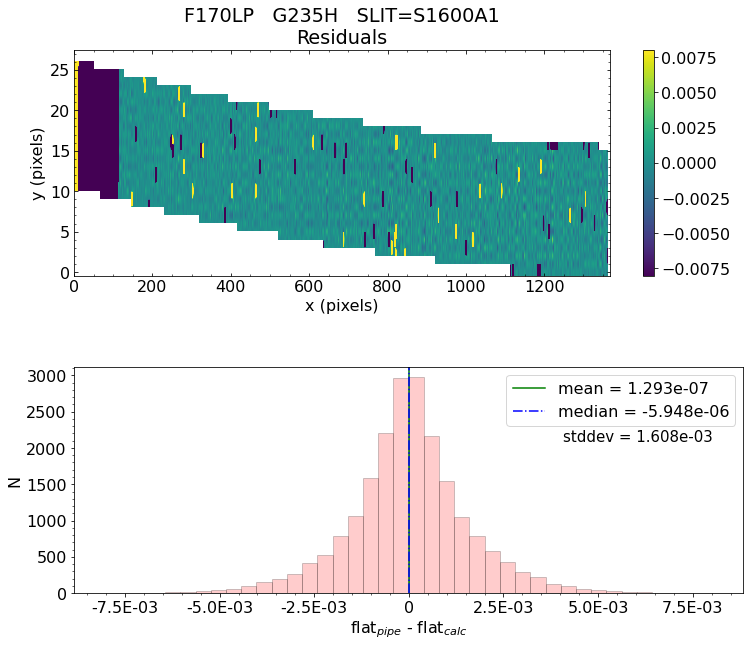


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_fs.py took ', '20.3505642414093 seconds to finish.')
Did flat_field for  bots_g235h_f170lp  validation test passed?  All slits PASSED flat_field test. 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/bots_g235h_f170lp_nrs1_interpolatedflat.fits', fd=66) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_dflat_nrs1_f_01.03.fits', fd=67) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs1_f_01.01.fits', fd=68) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_fflat_F170LP_01.01.fits', fd=69) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/bots_g235h_f170lp_nrs1_interpolatedflat.

2022-09-23 18:18:46,928 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf
2022-09-23 18:18:46,953 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-09-23 18:18:46,955 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-09-23 18:18:46,956 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-09-23 18:18:46,957 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-09-23 18:18:46,959 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-09-23 18:18:46,960 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-09-23 18:18:46,961 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-09-23 18:18:46,962 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-09-23 18:18:46,964 - stpipe.Detector1

2022-09-23 18:18:48,721 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0009.fits'.
2022-09-23 18:18:48,722 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0025.fits'.
2022-09-23 18:18:48,723 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0007.fits'.
2022-09-23 18:18:48,723 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-09-23 18:18:48,724 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-09-23 18:18:48,724 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0011.fits'.
2022-09-23 18:18:48,725 - stpipe.Detector1Pipeline - INFO - Pre

2022-09-23 18:19:52,604 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2022-09-23 18:19:53,019 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).
2022-09-23 18:19:53,020 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz', 'dark_output': None}
2022-09-23 18:19:53,053 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0122.fits
2022-09-23 18:19:53,151 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3000, ngroups

2022-09-23 18:20:14,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:14,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:14,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2100 pixels with at least one CR from three groups.
2022-09-23 18:20:14,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:
2022-09-23 18:20:14,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:14,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:14,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26279 pixels with at least one

2022-09-23 18:20:22,109 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:
2022-09-23 18:20:22,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:22,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:22,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13124 pixels with at least one CR from three groups.
2022-09-23 18:20:22,547 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 26:
2022-09-23 18:20:22,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:22,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:22,564 - stpipe.Detecto

2022-09-23 18:20:26,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2778 pixels with at least one CR from three groups.
2022-09-23 18:20:26,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:
2022-09-23 18:20:26,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:26,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:26,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 256 pixels with at least one CR from three groups.
2022-09-23 18:20:26,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:
2022-09-23 18:20:26,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:26,958 - stpipe.Detec

2022-09-23 18:20:30,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:30,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6938 pixels with at least one CR from three groups.
2022-09-23 18:20:31,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 55:
2022-09-23 18:20:31,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:31,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:31,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.
2022-09-23 18:20:31,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 56:
2022-09-23 18:20:31,085 - stpipe.Detector1Pipe

2022-09-23 18:20:37,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:37,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:37,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40209 pixels with at least one CR from three groups.
2022-09-23 18:20:38,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 70:
2022-09-23 18:20:38,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:38,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:38,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one 

2022-09-23 18:20:43,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 84:
2022-09-23 18:20:43,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:43,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:43,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9233 pixels with at least one CR from three groups.
2022-09-23 18:20:43,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 85:
2022-09-23 18:20:43,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:43,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:43,635 - stpipe.Detector

2022-09-23 18:20:53,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2680 pixels with at least one CR from three groups.
2022-09-23 18:20:53,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 99:
2022-09-23 18:20:53,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:53,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:20:53,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10646 pixels with at least one CR from three groups.
2022-09-23 18:20:53,753 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 100:
2022-09-23 18:20:53,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:20:53,770 - stpipe.De

2022-09-23 18:21:06,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:06,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1800 pixels with at least one CR from three groups.
2022-09-23 18:21:06,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 114:
2022-09-23 18:21:06,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:06,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:06,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1519 pixels with at least one CR from three groups.
2022-09-23 18:21:06,782 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 115:
2022-09-23 18:21:06,799 - stpipe.Detector1P

2022-09-23 18:21:16,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:16,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:16,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14286 pixels with at least one CR from three groups.
2022-09-23 18:21:16,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 129:
2022-09-23 18:21:16,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:16,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:16,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35022 pixels with at least o

2022-09-23 18:21:23,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 143:
2022-09-23 18:21:23,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:23,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:23,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1795 pixels with at least one CR from three groups.
2022-09-23 18:21:23,888 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 144:
2022-09-23 18:21:23,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:23,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:23,905 - stpipe.Detect

2022-09-23 18:21:32,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2042 pixels with at least one CR from three groups.
2022-09-23 18:21:32,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 158:
2022-09-23 18:21:32,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:32,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:32,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5569 pixels with at least one CR from three groups.
2022-09-23 18:21:32,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 159:
2022-09-23 18:21:32,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:32,846 - stpipe.De

2022-09-23 18:21:39,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:39,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.
2022-09-23 18:21:39,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 173:
2022-09-23 18:21:39,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:39,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:39,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57713 pixels with at least one CR from three groups.
2022-09-23 18:21:42,651 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 174:
2022-09-23 18:21:42,670 - stpipe.Detector1P

2022-09-23 18:21:48,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:48,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:48,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5439 pixels with at least one CR from three groups.
2022-09-23 18:21:48,886 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 188:
2022-09-23 18:21:48,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:48,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:48,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 942 pixels with at least one 

2022-09-23 18:21:53,623 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 202:
2022-09-23 18:21:53,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:53,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:53,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55991 pixels with at least one CR from three groups.
2022-09-23 18:21:55,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 203:
2022-09-23 18:21:55,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:55,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:55,774 - stpipe.Detec

2022-09-23 18:21:58,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4768 pixels with at least one CR from three groups.
2022-09-23 18:21:58,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 217:
2022-09-23 18:21:58,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:58,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:21:58,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 422 pixels with at least one CR from three groups.
2022-09-23 18:21:58,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 218:
2022-09-23 18:21:58,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:21:58,421 - stpipe.Det

2022-09-23 18:22:05,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:05,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59416 pixels with at least one CR from three groups.
2022-09-23 18:22:09,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 232:
2022-09-23 18:22:09,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:09,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:09,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16918 pixels with at least one CR from three groups.
2022-09-23 18:22:09,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 233:
2022-09-23 18:22:09,583 - stpipe.Detector

2022-09-23 18:22:17,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:17,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:17,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1516 pixels with at least one CR from three groups.
2022-09-23 18:22:17,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 247:
2022-09-23 18:22:17,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:17,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:17,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 677 pixels with at least one 

2022-09-23 18:22:27,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 261:
2022-09-23 18:22:27,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:27,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:27,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53505 pixels with at least one CR from three groups.
2022-09-23 18:22:29,347 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 262:
2022-09-23 18:22:29,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:29,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:29,364 - stpipe.Detec

2022-09-23 18:22:31,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40782 pixels with at least one CR from three groups.
2022-09-23 18:22:32,389 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 276:
2022-09-23 18:22:32,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:32,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:32,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 292 pixels with at least one CR from three groups.
2022-09-23 18:22:32,424 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 277:
2022-09-23 18:22:32,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:32,440 - stpipe.De

2022-09-23 18:22:37,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:37,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10483 pixels with at least one CR from three groups.
2022-09-23 18:22:37,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 291:
2022-09-23 18:22:37,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:37,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:37,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5829 pixels with at least one CR from three groups.
2022-09-23 18:22:38,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 292:
2022-09-23 18:22:38,183 - stpipe.Detector1

2022-09-23 18:22:44,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:44,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:44,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.
2022-09-23 18:22:44,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 306:
2022-09-23 18:22:44,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:44,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:44,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2697 pixels with at least one 

2022-09-23 18:22:59,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 320:
2022-09-23 18:22:59,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:59,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:59,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15389 pixels with at least one CR from three groups.
2022-09-23 18:22:59,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 321:
2022-09-23 18:22:59,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:22:59,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:22:59,991 - stpipe.Detec

2022-09-23 18:23:04,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20383 pixels with at least one CR from three groups.
2022-09-23 18:23:05,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 335:
2022-09-23 18:23:05,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:05,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:05,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.
2022-09-23 18:23:05,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 336:
2022-09-23 18:23:05,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:05,596 - stpipe.De

2022-09-23 18:23:11,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:11,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 715 pixels with at least one CR from three groups.
2022-09-23 18:23:11,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 350:
2022-09-23 18:23:11,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:11,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:11,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4896 pixels with at least one CR from three groups.
2022-09-23 18:23:12,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 351:
2022-09-23 18:23:12,025 - stpipe.Detector1Pi

2022-09-23 18:23:20,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:20,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:20,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 259 pixels with at least one CR from three groups.
2022-09-23 18:23:20,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 365:
2022-09-23 18:23:20,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:20,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:20,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2942 pixels with at least one 

2022-09-23 18:23:26,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 379:
2022-09-23 18:23:26,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:26,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:26,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2433 pixels with at least one CR from three groups.
2022-09-23 18:23:26,129 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 380:
2022-09-23 18:23:26,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:26,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:26,146 - stpipe.Detect

2022-09-23 18:23:34,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3457 pixels with at least one CR from three groups.
2022-09-23 18:23:34,266 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 394:
2022-09-23 18:23:34,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:34,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:34,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31331 pixels with at least one CR from three groups.
2022-09-23 18:23:35,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 395:
2022-09-23 18:23:35,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:35,357 - stpipe.D

2022-09-23 18:23:42,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:42,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52726 pixels with at least one CR from three groups.
2022-09-23 18:23:43,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 409:
2022-09-23 18:23:44,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:44,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:44,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12815 pixels with at least one CR from three groups.
2022-09-23 18:23:44,430 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 410:
2022-09-23 18:23:44,446 - stpipe.Detector

2022-09-23 18:23:48,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:48,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:48,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.
2022-09-23 18:23:48,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 424:
2022-09-23 18:23:48,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:48,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:48,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 399 pixels with at least one C

2022-09-23 18:23:54,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 438:
2022-09-23 18:23:54,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:54,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:54,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 420 pixels with at least one CR from three groups.
2022-09-23 18:23:54,106 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 439:
2022-09-23 18:23:54,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:23:54,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:23:54,123 - stpipe.Detecto

2022-09-23 18:23:59,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.
2022-09-23 18:24:00,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 453:
2022-09-23 18:24:00,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:00,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:00,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3440 pixels with at least one CR from three groups.
2022-09-23 18:24:00,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 454:
2022-09-23 18:24:00,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:00,175 - stpipe.Det

2022-09-23 18:24:06,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:06,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50270 pixels with at least one CR from three groups.
2022-09-23 18:24:08,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 468:
2022-09-23 18:24:08,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:08,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:08,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1468 pixels with at least one CR from three groups.
2022-09-23 18:24:08,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 469:
2022-09-23 18:24:08,653 - stpipe.Detector1

2022-09-23 18:24:11,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:11,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:11,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28564 pixels with at least one CR from three groups.
2022-09-23 18:24:12,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 483:
2022-09-23 18:24:12,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:12,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:12,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34325 pixels with at least o

2022-09-23 18:24:18,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 497:
2022-09-23 18:24:18,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:18,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:18,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2811 pixels with at least one CR from three groups.
2022-09-23 18:24:18,590 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 498:
2022-09-23 18:24:18,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:18,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:18,608 - stpipe.Detect

2022-09-23 18:24:29,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.
2022-09-23 18:24:29,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 512:
2022-09-23 18:24:29,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:29,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:29,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8575 pixels with at least one CR from three groups.
2022-09-23 18:24:29,930 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 513:
2022-09-23 18:24:29,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:29,949 - stpipe.Det

2022-09-23 18:24:32,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:32,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11505 pixels with at least one CR from three groups.
2022-09-23 18:24:33,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 527:
2022-09-23 18:24:33,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:33,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:33,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8580 pixels with at least one CR from three groups.
2022-09-23 18:24:33,432 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 528:
2022-09-23 18:24:33,452 - stpipe.Detector1

2022-09-23 18:24:36,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:36,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:36,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.
2022-09-23 18:24:36,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 542:
2022-09-23 18:24:36,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:36,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:36,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6326 pixels with at least one 

2022-09-23 18:24:42,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 556:
2022-09-23 18:24:42,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:42,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:42,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58798 pixels with at least one CR from three groups.
2022-09-23 18:24:45,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 557:
2022-09-23 18:24:45,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:45,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:45,634 - stpipe.Detec

2022-09-23 18:24:54,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.
2022-09-23 18:24:54,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 571:
2022-09-23 18:24:54,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:54,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:24:54,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4002 pixels with at least one CR from three groups.
2022-09-23 18:24:54,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 572:
2022-09-23 18:24:54,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:24:54,986 - stpipe.Det

2022-09-23 18:25:00,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:00,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48357 pixels with at least one CR from three groups.
2022-09-23 18:25:02,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 586:
2022-09-23 18:25:02,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:02,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:02,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8111 pixels with at least one CR from three groups.
2022-09-23 18:25:02,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 587:
2022-09-23 18:25:02,539 - stpipe.Detector1

2022-09-23 18:25:13,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:13,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:13,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8544 pixels with at least one CR from three groups.
2022-09-23 18:25:13,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 601:
2022-09-23 18:25:13,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:13,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:13,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1149 pixels with at least one

2022-09-23 18:25:18,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 615:
2022-09-23 18:25:18,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:18,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:18,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1428 pixels with at least one CR from three groups.
2022-09-23 18:25:18,215 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 616:
2022-09-23 18:25:18,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:18,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:18,235 - stpipe.Detect

2022-09-23 18:25:28,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.
2022-09-23 18:25:28,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 630:
2022-09-23 18:25:28,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:28,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:28,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24429 pixels with at least one CR from three groups.
2022-09-23 18:25:29,437 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 631:
2022-09-23 18:25:29,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:29,455 - stpipe.De

2022-09-23 18:25:37,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:37,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3705 pixels with at least one CR from three groups.
2022-09-23 18:25:37,977 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 645:
2022-09-23 18:25:37,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:37,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:37,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.
2022-09-23 18:25:38,013 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 646:
2022-09-23 18:25:38,029 - stpipe.Detector1Pi

2022-09-23 18:25:48,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:48,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:48,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48108 pixels with at least one CR from three groups.
2022-09-23 18:25:49,780 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 660:
2022-09-23 18:25:49,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:49,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:49,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44093 pixels with at least o

2022-09-23 18:25:56,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 674:
2022-09-23 18:25:56,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:56,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:56,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 342 pixels with at least one CR from three groups.
2022-09-23 18:25:56,173 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 675:
2022-09-23 18:25:56,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:25:56,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:25:56,191 - stpipe.Detecto

2022-09-23 18:26:04,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.
2022-09-23 18:26:04,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 689:
2022-09-23 18:26:04,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:04,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:04,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57626 pixels with at least one CR from three groups.
2022-09-23 18:26:07,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 690:
2022-09-23 18:26:07,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:07,168 - stpipe.De

2022-09-23 18:26:19,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:19,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47607 pixels with at least one CR from three groups.
2022-09-23 18:26:21,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 704:
2022-09-23 18:26:21,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:21,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:21,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12474 pixels with at least one CR from three groups.
2022-09-23 18:26:21,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 705:
2022-09-23 18:26:21,687 - stpipe.Detector

2022-09-23 18:26:30,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:30,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:30,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7238 pixels with at least one CR from three groups.
2022-09-23 18:26:30,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 719:
2022-09-23 18:26:30,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:30,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:30,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4332 pixels with at least one

2022-09-23 18:26:36,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 733:
2022-09-23 18:26:36,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:36,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:36,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5440 pixels with at least one CR from three groups.
2022-09-23 18:26:36,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 734:
2022-09-23 18:26:37,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:37,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:37,011 - stpipe.Detect

2022-09-23 18:26:44,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35463 pixels with at least one CR from three groups.
2022-09-23 18:26:45,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 748:
2022-09-23 18:26:45,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:45,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:45,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.
2022-09-23 18:26:45,329 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 749:
2022-09-23 18:26:45,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:45,346 - stpipe.De

2022-09-23 18:26:50,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:50,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38741 pixels with at least one CR from three groups.
2022-09-23 18:26:51,442 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 763:
2022-09-23 18:26:51,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:26:51,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:26:51,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9769 pixels with at least one CR from three groups.
2022-09-23 18:26:51,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 764:
2022-09-23 18:26:51,786 - stpipe.Detector1

2022-09-23 18:27:00,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:00,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:00,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1326 pixels with at least one CR from three groups.
2022-09-23 18:27:00,144 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 778:
2022-09-23 18:27:00,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:00,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:00,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 667 pixels with at least one 

2022-09-23 18:27:04,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 792:
2022-09-23 18:27:04,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:04,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:04,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1362 pixels with at least one CR from three groups.
2022-09-23 18:27:04,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 793:
2022-09-23 18:27:04,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:04,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:04,909 - stpipe.Detect

2022-09-23 18:27:10,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 851 pixels with at least one CR from three groups.
2022-09-23 18:27:10,353 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 807:
2022-09-23 18:27:10,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:10,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:10,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2364 pixels with at least one CR from three groups.
2022-09-23 18:27:10,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 808:
2022-09-23 18:27:10,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:10,469 - stpipe.Det

2022-09-23 18:27:14,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:14,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.
2022-09-23 18:27:14,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 822:
2022-09-23 18:27:14,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:14,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:14,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.
2022-09-23 18:27:14,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 823:
2022-09-23 18:27:14,504 - stpipe.Detector1Pip

2022-09-23 18:27:20,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:20,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:20,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2909 pixels with at least one CR from three groups.
2022-09-23 18:27:20,992 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 837:
2022-09-23 18:27:21,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:21,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:21,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23188 pixels with at least on

2022-09-23 18:27:25,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 851:
2022-09-23 18:27:26,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:26,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:26,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3594 pixels with at least one CR from three groups.
2022-09-23 18:27:26,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 852:
2022-09-23 18:27:26,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:26,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:26,156 - stpipe.Detect

2022-09-23 18:27:36,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.
2022-09-23 18:27:36,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 866:
2022-09-23 18:27:36,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:36,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:36,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27203 pixels with at least one CR from three groups.
2022-09-23 18:27:36,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 867:
2022-09-23 18:27:37,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:37,013 - stpipe.De

2022-09-23 18:27:46,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:46,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 766 pixels with at least one CR from three groups.
2022-09-23 18:27:46,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 881:
2022-09-23 18:27:46,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:27:46,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:27:46,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19536 pixels with at least one CR from three groups.
2022-09-23 18:27:47,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 882:
2022-09-23 18:27:47,223 - stpipe.Detector1P

2022-09-23 18:28:01,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:01,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:01,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4290 pixels with at least one CR from three groups.
2022-09-23 18:28:01,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 896:
2022-09-23 18:28:01,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:01,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:01,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one 

2022-09-23 18:28:07,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 910:
2022-09-23 18:28:07,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:07,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:07,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.
2022-09-23 18:28:07,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 911:
2022-09-23 18:28:07,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:07,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:07,186 - stpipe.Detecto

2022-09-23 18:28:12,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 682 pixels with at least one CR from three groups.
2022-09-23 18:28:12,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 925:
2022-09-23 18:28:12,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:12,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:12,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one CR from three groups.
2022-09-23 18:28:12,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 926:
2022-09-23 18:28:12,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:12,383 - stpipe.Dete

2022-09-23 18:28:15,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:15,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43245 pixels with at least one CR from three groups.
2022-09-23 18:28:17,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 940:
2022-09-23 18:28:17,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:17,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:17,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33493 pixels with at least one CR from three groups.
2022-09-23 18:28:18,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 941:
2022-09-23 18:28:18,393 - stpipe.Detector

2022-09-23 18:28:30,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:30,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:30,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41957 pixels with at least one CR from three groups.
2022-09-23 18:28:31,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 955:
2022-09-23 18:28:31,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:31,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:31,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1490 pixels with at least on

2022-09-23 18:28:44,401 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 969:
2022-09-23 18:28:44,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:44,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:44,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9397 pixels with at least one CR from three groups.
2022-09-23 18:28:44,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 970:
2022-09-23 18:28:44,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:44,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:44,737 - stpipe.Detect

2022-09-23 18:28:47,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1020 pixels with at least one CR from three groups.
2022-09-23 18:28:47,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 984:
2022-09-23 18:28:47,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:47,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:47,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 989 pixels with at least one CR from three groups.
2022-09-23 18:28:47,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 985:
2022-09-23 18:28:47,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:47,992 - stpipe.Det

2022-09-23 18:28:50,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:50,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11690 pixels with at least one CR from three groups.
2022-09-23 18:28:50,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 999:
2022-09-23 18:28:50,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:50,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:50,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1960 pixels with at least one CR from three groups.
2022-09-23 18:28:50,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1000:
2022-09-23 18:28:50,859 - stpipe.Detector

2022-09-23 18:28:56,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:56,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:56,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 875 pixels with at least one CR from three groups.
2022-09-23 18:28:56,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1014:
2022-09-23 18:28:56,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:28:56,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:28:56,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one 

2022-09-23 18:29:02,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1028:
2022-09-23 18:29:02,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:02,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:02,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32936 pixels with at least one CR from three groups.
2022-09-23 18:29:03,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1029:
2022-09-23 18:29:03,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:03,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:03,308 - stpipe.Det

2022-09-23 18:29:10,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.
2022-09-23 18:29:10,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1043:
2022-09-23 18:29:10,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:10,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:10,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3038 pixels with at least one CR from three groups.
2022-09-23 18:29:10,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1044:
2022-09-23 18:29:10,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:10,255 - stpipe.D

2022-09-23 18:29:16,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:16,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.
2022-09-23 18:29:16,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1058:
2022-09-23 18:29:16,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:16,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:16,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6790 pixels with at least one CR from three groups.
2022-09-23 18:29:17,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1059:
2022-09-23 18:29:17,038 - stpipe.Detector1

2022-09-23 18:29:23,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:23,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:23,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.
2022-09-23 18:29:23,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1073:
2022-09-23 18:29:23,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:23,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:23,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one 

2022-09-23 18:29:30,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1087:
2022-09-23 18:29:30,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:30,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:30,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.
2022-09-23 18:29:30,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1088:
2022-09-23 18:29:30,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:30,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:30,345 - stpipe.Detec

2022-09-23 18:29:41,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 449 pixels with at least one CR from three groups.
2022-09-23 18:29:41,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1102:
2022-09-23 18:29:41,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:41,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:41,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6976 pixels with at least one CR from three groups.
2022-09-23 18:29:41,392 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1103:
2022-09-23 18:29:41,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:41,410 - stpipe.D

2022-09-23 18:29:44,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:44,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5368 pixels with at least one CR from three groups.
2022-09-23 18:29:44,706 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1117:
2022-09-23 18:29:44,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:44,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:44,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.
2022-09-23 18:29:44,739 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1118:
2022-09-23 18:29:44,758 - stpipe.Detector1

2022-09-23 18:29:48,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:48,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:48,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45751 pixels with at least one CR from three groups.
2022-09-23 18:29:50,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1132:
2022-09-23 18:29:50,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:50,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:50,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1194 pixels with at least o

2022-09-23 18:29:56,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1146:
2022-09-23 18:29:56,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:56,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:56,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1483 pixels with at least one CR from three groups.
2022-09-23 18:29:56,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1147:
2022-09-23 18:29:56,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:29:56,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:29:56,543 - stpipe.Dete

2022-09-23 18:30:00,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 445 pixels with at least one CR from three groups.
2022-09-23 18:30:00,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1161:
2022-09-23 18:30:00,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:00,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:00,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45688 pixels with at least one CR from three groups.
2022-09-23 18:30:02,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1162:
2022-09-23 18:30:02,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:02,181 - stpipe.

2022-09-23 18:30:08,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:08,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.
2022-09-23 18:30:08,152 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1176:
2022-09-23 18:30:08,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:08,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:08,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2362 pixels with at least one CR from three groups.
2022-09-23 18:30:08,248 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1177:
2022-09-23 18:30:08,265 - stpipe.Detector1

2022-09-23 18:30:16,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:16,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:16,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45871 pixels with at least one CR from three groups.
2022-09-23 18:30:17,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1191:
2022-09-23 18:30:17,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:17,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:17,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 324 pixels with at least on

2022-09-23 18:30:23,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1205:
2022-09-23 18:30:23,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:23,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:23,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.
2022-09-23 18:30:23,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1206:
2022-09-23 18:30:23,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:23,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:23,716 - stpipe.Detec

2022-09-23 18:30:26,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50473 pixels with at least one CR from three groups.
2022-09-23 18:30:27,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1220:
2022-09-23 18:30:27,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:27,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:27,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.
2022-09-23 18:30:27,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1221:
2022-09-23 18:30:27,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:27,814 - stpipe.

2022-09-23 18:30:34,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:34,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1553 pixels with at least one CR from three groups.
2022-09-23 18:30:34,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1235:
2022-09-23 18:30:34,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:34,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:34,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 447 pixels with at least one CR from three groups.
2022-09-23 18:30:34,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1236:
2022-09-23 18:30:34,686 - stpipe.Detector1

2022-09-23 18:30:41,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:41,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:41,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9737 pixels with at least one CR from three groups.
2022-09-23 18:30:41,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1250:
2022-09-23 18:30:41,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:41,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:41,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one

2022-09-23 18:30:44,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1264:
2022-09-23 18:30:44,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:44,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:44,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14256 pixels with at least one CR from three groups.
2022-09-23 18:30:44,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1265:
2022-09-23 18:30:44,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:44,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:44,493 - stpipe.Det

2022-09-23 18:30:47,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48712 pixels with at least one CR from three groups.
2022-09-23 18:30:49,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1279:
2022-09-23 18:30:49,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:49,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:49,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41035 pixels with at least one CR from three groups.
2022-09-23 18:30:50,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1280:
2022-09-23 18:30:50,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:50,897 - stpip

2022-09-23 18:30:54,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:54,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13343 pixels with at least one CR from three groups.
2022-09-23 18:30:55,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1294:
2022-09-23 18:30:55,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:30:55,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:30:55,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 735 pixels with at least one CR from three groups.
2022-09-23 18:30:55,431 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1295:
2022-09-23 18:30:55,446 - stpipe.Detector

2022-09-23 18:31:02,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:02,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:02,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 322 pixels with at least one CR from three groups.
2022-09-23 18:31:02,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1309:
2022-09-23 18:31:02,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:02,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:02,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one 

2022-09-23 18:31:07,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1323:
2022-09-23 18:31:07,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:07,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:07,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.
2022-09-23 18:31:07,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1324:
2022-09-23 18:31:07,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:07,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:07,528 - stpipe.Detec

2022-09-23 18:31:13,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15628 pixels with at least one CR from three groups.
2022-09-23 18:31:14,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1338:
2022-09-23 18:31:14,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:14,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:14,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 482 pixels with at least one CR from three groups.
2022-09-23 18:31:14,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1339:
2022-09-23 18:31:14,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:14,263 - stpipe.

2022-09-23 18:31:16,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:16,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11563 pixels with at least one CR from three groups.
2022-09-23 18:31:16,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1353:
2022-09-23 18:31:16,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:16,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:16,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 376 pixels with at least one CR from three groups.
2022-09-23 18:31:16,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1354:
2022-09-23 18:31:16,999 - stpipe.Detector

2022-09-23 18:31:24,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:24,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:24,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 401 pixels with at least one CR from three groups.
2022-09-23 18:31:24,505 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1368:
2022-09-23 18:31:24,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:24,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:24,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49413 pixels with at least on

2022-09-23 18:31:33,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1382:
2022-09-23 18:31:33,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:33,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:33,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4215 pixels with at least one CR from three groups.
2022-09-23 18:31:33,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1383:
2022-09-23 18:31:33,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:33,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:33,527 - stpipe.Dete

2022-09-23 18:31:46,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 241 pixels with at least one CR from three groups.
2022-09-23 18:31:46,087 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1397:
2022-09-23 18:31:46,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:46,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:46,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2754 pixels with at least one CR from three groups.
2022-09-23 18:31:46,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1398:
2022-09-23 18:31:46,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:46,225 - stpipe.D

2022-09-23 18:31:50,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:50,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50472 pixels with at least one CR from three groups.
2022-09-23 18:31:51,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1412:
2022-09-23 18:31:51,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:52,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:52,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2998 pixels with at least one CR from three groups.
2022-09-23 18:31:52,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1413:
2022-09-23 18:31:52,121 - stpipe.Detecto

2022-09-23 18:31:56,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:56,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:56,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5381 pixels with at least one CR from three groups.
2022-09-23 18:31:57,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1427:
2022-09-23 18:31:57,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:31:57,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:31:57,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one

2022-09-23 18:32:03,467 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1441:
2022-09-23 18:32:03,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:03,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:03,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.
2022-09-23 18:32:03,500 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1442:
2022-09-23 18:32:03,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:03,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:03,517 - stpipe.Detec

2022-09-23 18:32:06,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11877 pixels with at least one CR from three groups.
2022-09-23 18:32:06,543 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1456:
2022-09-23 18:32:06,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:06,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:06,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34532 pixels with at least one CR from three groups.
2022-09-23 18:32:07,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1457:
2022-09-23 18:32:07,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:07,664 - stpip

2022-09-23 18:32:09,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:09,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 307 pixels with at least one CR from three groups.
2022-09-23 18:32:09,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1471:
2022-09-23 18:32:09,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:09,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:09,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40911 pixels with at least one CR from three groups.
2022-09-23 18:32:10,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1472:
2022-09-23 18:32:10,557 - stpipe.Detector

2022-09-23 18:32:16,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:16,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:16,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 303 pixels with at least one CR from three groups.
2022-09-23 18:32:16,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1486:
2022-09-23 18:32:16,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:16,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:16,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48472 pixels with at least on

2022-09-23 18:32:25,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1500:
2022-09-23 18:32:25,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:25,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:25,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.
2022-09-23 18:32:25,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1501:
2022-09-23 18:32:25,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:25,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:25,249 - stpipe.Detec

2022-09-23 18:32:35,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60553 pixels with at least one CR from three groups.
2022-09-23 18:32:39,162 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1515:
2022-09-23 18:32:39,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:39,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:39,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 229 pixels with at least one CR from three groups.
2022-09-23 18:32:39,194 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1516:
2022-09-23 18:32:39,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:39,211 - stpipe.

2022-09-23 18:32:43,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:43,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.
2022-09-23 18:32:43,692 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1530:
2022-09-23 18:32:43,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:43,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:43,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48521 pixels with at least one CR from three groups.
2022-09-23 18:32:45,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1531:
2022-09-23 18:32:45,331 - stpipe.Detector

2022-09-23 18:32:53,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:53,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:53,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.
2022-09-23 18:32:53,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1545:
2022-09-23 18:32:53,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:32:53,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:32:53,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 409 pixels with at least one 

2022-09-23 18:33:02,485 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1559:
2022-09-23 18:33:02,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:02,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:02,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10315 pixels with at least one CR from three groups.
2022-09-23 18:33:02,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1560:
2022-09-23 18:33:02,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:02,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:02,882 - stpipe.Det

2022-09-23 18:33:06,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.
2022-09-23 18:33:06,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1574:
2022-09-23 18:33:06,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:06,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:06,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.
2022-09-23 18:33:06,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1575:
2022-09-23 18:33:06,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:06,476 - stpipe.De

2022-09-23 18:33:09,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:09,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.
2022-09-23 18:33:09,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1589:
2022-09-23 18:33:09,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:09,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:09,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55821 pixels with at least one CR from three groups.
2022-09-23 18:33:11,598 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1590:
2022-09-23 18:33:11,617 - stpipe.Detector

2022-09-23 18:33:17,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:17,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:17,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54139 pixels with at least one CR from three groups.
2022-09-23 18:33:19,444 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1604:
2022-09-23 18:33:19,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:19,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:19,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2817 pixels with at least o

2022-09-23 18:33:24,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1618:
2022-09-23 18:33:24,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:24,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:24,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.
2022-09-23 18:33:24,441 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1619:
2022-09-23 18:33:24,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:24,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:24,457 - stpipe.Detec

2022-09-23 18:33:29,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4529 pixels with at least one CR from three groups.
2022-09-23 18:33:29,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1633:
2022-09-23 18:33:29,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:29,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:29,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 343 pixels with at least one CR from three groups.
2022-09-23 18:33:29,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1634:
2022-09-23 18:33:29,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:29,862 - stpipe.D

2022-09-23 18:33:36,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:36,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.
2022-09-23 18:33:36,814 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1648:
2022-09-23 18:33:36,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:36,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:36,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.
2022-09-23 18:33:36,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1649:
2022-09-23 18:33:36,865 - stpipe.Detector1P

2022-09-23 18:33:41,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:41,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:41,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 336 pixels with at least one CR from three groups.
2022-09-23 18:33:41,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1663:
2022-09-23 18:33:41,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:41,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:41,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3399 pixels with at least one

2022-09-23 18:33:51,114 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1677:
2022-09-23 18:33:51,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:51,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:51,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1699 pixels with at least one CR from three groups.
2022-09-23 18:33:51,196 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1678:
2022-09-23 18:33:51,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:51,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:51,213 - stpipe.Dete

2022-09-23 18:33:56,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54212 pixels with at least one CR from three groups.
2022-09-23 18:33:58,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1692:
2022-09-23 18:33:58,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:58,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:33:58,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.
2022-09-23 18:33:58,377 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1693:
2022-09-23 18:33:58,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:33:58,393 - stpipe.

2022-09-23 18:34:00,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:00,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11342 pixels with at least one CR from three groups.
2022-09-23 18:34:00,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1707:
2022-09-23 18:34:00,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:00,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:00,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 369 pixels with at least one CR from three groups.
2022-09-23 18:34:00,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1708:
2022-09-23 18:34:00,781 - stpipe.Detector

2022-09-23 18:34:05,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:05,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:05,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.
2022-09-23 18:34:05,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1722:
2022-09-23 18:34:05,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:05,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:05,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 212 pixels with at least one 

2022-09-23 18:34:12,127 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1736:
2022-09-23 18:34:12,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:12,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:12,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 423 pixels with at least one CR from three groups.
2022-09-23 18:34:12,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1737:
2022-09-23 18:34:12,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:12,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:12,184 - stpipe.Detec

2022-09-23 18:34:21,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 316 pixels with at least one CR from three groups.
2022-09-23 18:34:21,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1751:
2022-09-23 18:34:21,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:21,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:21,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 748 pixels with at least one CR from three groups.
2022-09-23 18:34:21,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1752:
2022-09-23 18:34:21,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:21,185 - stpipe.De

2022-09-23 18:34:28,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:28,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.
2022-09-23 18:34:28,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1766:
2022-09-23 18:34:28,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:28,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:28,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 242 pixels with at least one CR from three groups.
2022-09-23 18:34:28,269 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1767:
2022-09-23 18:34:28,285 - stpipe.Detector1P

2022-09-23 18:34:40,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:40,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:40,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1043 pixels with at least one CR from three groups.
2022-09-23 18:34:40,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1781:
2022-09-23 18:34:40,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:40,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:40,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 389 pixels with at least one

2022-09-23 18:34:46,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1795:
2022-09-23 18:34:46,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:46,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:46,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2925 pixels with at least one CR from three groups.
2022-09-23 18:34:46,817 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1796:
2022-09-23 18:34:46,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:46,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:46,833 - stpipe.Dete

2022-09-23 18:34:52,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53257 pixels with at least one CR from three groups.
2022-09-23 18:34:53,869 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1810:
2022-09-23 18:34:53,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:53,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:53,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 326 pixels with at least one CR from three groups.
2022-09-23 18:34:53,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1811:
2022-09-23 18:34:53,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:53,922 - stpipe.

2022-09-23 18:34:59,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:59,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.
2022-09-23 18:34:59,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1825:
2022-09-23 18:34:59,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:34:59,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:34:59,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38788 pixels with at least one CR from three groups.
2022-09-23 18:35:00,719 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1826:
2022-09-23 18:35:00,735 - stpipe.Detector

2022-09-23 18:35:08,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:08,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:08,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.
2022-09-23 18:35:08,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1840:
2022-09-23 18:35:08,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:08,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:08,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3548 pixels with at least one

2022-09-23 18:35:13,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1854:
2022-09-23 18:35:13,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:13,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:13,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33224 pixels with at least one CR from three groups.
2022-09-23 18:35:14,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1855:
2022-09-23 18:35:14,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:14,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:14,370 - stpipe.Det

2022-09-23 18:35:24,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.
2022-09-23 18:35:24,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1869:
2022-09-23 18:35:24,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:24,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:24,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29396 pixels with at least one CR from three groups.
2022-09-23 18:35:25,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1870:
2022-09-23 18:35:25,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:25,470 - stpipe.

2022-09-23 18:35:28,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:28,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21804 pixels with at least one CR from three groups.
2022-09-23 18:35:28,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1884:
2022-09-23 18:35:28,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:28,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:28,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.
2022-09-23 18:35:28,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1885:
2022-09-23 18:35:28,855 - stpipe.Detector

2022-09-23 18:35:33,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:33,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:33,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.
2022-09-23 18:35:33,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1899:
2022-09-23 18:35:33,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:33,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:33,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51373 pixels with at least on

2022-09-23 18:35:39,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1913:
2022-09-23 18:35:39,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:39,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:39,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8843 pixels with at least one CR from three groups.
2022-09-23 18:35:40,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1914:
2022-09-23 18:35:40,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:40,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:40,171 - stpipe.Dete

2022-09-23 18:35:47,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28747 pixels with at least one CR from three groups.
2022-09-23 18:35:48,505 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1928:
2022-09-23 18:35:48,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:48,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:35:48,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41242 pixels with at least one CR from three groups.
2022-09-23 18:35:49,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1929:
2022-09-23 18:35:49,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:35:49,890 - stpip

2022-09-23 18:36:01,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:01,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.
2022-09-23 18:36:01,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1943:
2022-09-23 18:36:01,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:01,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:01,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11125 pixels with at least one CR from three groups.
2022-09-23 18:36:01,399 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1944:
2022-09-23 18:36:01,415 - stpipe.Detector

2022-09-23 18:36:06,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:06,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:06,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1921 pixels with at least one CR from three groups.
2022-09-23 18:36:06,899 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1958:
2022-09-23 18:36:06,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:06,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:06,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 347 pixels with at least one

2022-09-23 18:36:16,304 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1972:
2022-09-23 18:36:16,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:16,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:16,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 292 pixels with at least one CR from three groups.
2022-09-23 18:36:16,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1973:
2022-09-23 18:36:16,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:16,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:16,355 - stpipe.Detec

2022-09-23 18:36:21,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55310 pixels with at least one CR from three groups.
2022-09-23 18:36:23,079 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1987:
2022-09-23 18:36:23,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:23,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:23,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52663 pixels with at least one CR from three groups.
2022-09-23 18:36:24,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1988:
2022-09-23 18:36:24,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:24,842 - stpip

2022-09-23 18:36:37,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:37,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.
2022-09-23 18:36:37,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2002:
2022-09-23 18:36:37,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:37,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:37,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1439 pixels with at least one CR from three groups.
2022-09-23 18:36:37,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2003:
2022-09-23 18:36:37,289 - stpipe.Detector1

2022-09-23 18:36:44,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:44,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:44,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 404 pixels with at least one CR from three groups.
2022-09-23 18:36:44,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2017:
2022-09-23 18:36:44,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:44,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:44,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one 

2022-09-23 18:36:50,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2031:
2022-09-23 18:36:50,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:50,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:50,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13320 pixels with at least one CR from three groups.
2022-09-23 18:36:50,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2032:
2022-09-23 18:36:50,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:36:50,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:36:50,738 - stpipe.Det

2022-09-23 18:37:00,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.
2022-09-23 18:37:00,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2046:
2022-09-23 18:37:01,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:01,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:01,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 362 pixels with at least one CR from three groups.
2022-09-23 18:37:01,035 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2047:
2022-09-23 18:37:01,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:01,051 - stpipe.De

2022-09-23 18:37:04,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:04,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 371 pixels with at least one CR from three groups.
2022-09-23 18:37:04,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2061:
2022-09-23 18:37:04,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:04,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:04,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46982 pixels with at least one CR from three groups.
2022-09-23 18:37:06,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2062:
2022-09-23 18:37:06,370 - stpipe.Detector

2022-09-23 18:37:15,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:15,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:15,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13495 pixels with at least one CR from three groups.
2022-09-23 18:37:15,975 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2076:
2022-09-23 18:37:15,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:15,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:15,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17308 pixels with at least 

2022-09-23 18:37:21,605 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2090:
2022-09-23 18:37:21,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:21,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:21,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.
2022-09-23 18:37:21,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2091:
2022-09-23 18:37:21,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:21,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:21,662 - stpipe.Detec

2022-09-23 18:37:35,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60206 pixels with at least one CR from three groups.
2022-09-23 18:37:38,807 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2105:
2022-09-23 18:37:38,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:38,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:38,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.
2022-09-23 18:37:38,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2106:
2022-09-23 18:37:38,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:38,862 - stpipe.

2022-09-23 18:37:47,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:47,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.
2022-09-23 18:37:47,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2120:
2022-09-23 18:37:47,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:47,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:47,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44054 pixels with at least one CR from three groups.
2022-09-23 18:37:49,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2121:
2022-09-23 18:37:49,376 - stpipe.Detector

2022-09-23 18:37:58,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:58,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:58,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46905 pixels with at least one CR from three groups.
2022-09-23 18:37:59,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2135:
2022-09-23 18:37:59,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:37:59,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:37:59,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13882 pixels with at least 

2022-09-23 18:38:07,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2149:
2022-09-23 18:38:07,497 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:07,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:07,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.
2022-09-23 18:38:07,515 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2150:
2022-09-23 18:38:07,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:07,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:07,533 - stpipe.Detec

2022-09-23 18:38:17,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1890 pixels with at least one CR from three groups.
2022-09-23 18:38:17,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2164:
2022-09-23 18:38:17,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:17,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:17,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55570 pixels with at least one CR from three groups.
2022-09-23 18:38:19,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2165:
2022-09-23 18:38:19,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:19,475 - stpipe

2022-09-23 18:38:26,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:26,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1446 pixels with at least one CR from three groups.
2022-09-23 18:38:26,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2179:
2022-09-23 18:38:26,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:26,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:26,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 252 pixels with at least one CR from three groups.
2022-09-23 18:38:26,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2180:
2022-09-23 18:38:26,508 - stpipe.Detector1

2022-09-23 18:38:31,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:31,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:31,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31443 pixels with at least one CR from three groups.
2022-09-23 18:38:32,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2194:
2022-09-23 18:38:32,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:32,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:32,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4162 pixels with at least o

2022-09-23 18:38:33,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2208:
2022-09-23 18:38:34,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:34,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:34,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45629 pixels with at least one CR from three groups.
2022-09-23 18:38:35,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2209:
2022-09-23 18:38:35,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:35,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:35,529 - stpipe.Det

2022-09-23 18:38:43,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2092 pixels with at least one CR from three groups.
2022-09-23 18:38:43,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2223:
2022-09-23 18:38:43,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:43,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:43,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.
2022-09-23 18:38:43,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2224:
2022-09-23 18:38:43,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:43,727 - stpipe.D

2022-09-23 18:38:49,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:49,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 803 pixels with at least one CR from three groups.
2022-09-23 18:38:49,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2238:
2022-09-23 18:38:49,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:49,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:49,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55575 pixels with at least one CR from three groups.
2022-09-23 18:38:51,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2239:
2022-09-23 18:38:51,585 - stpipe.Detector

2022-09-23 18:38:56,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:56,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:56,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1695 pixels with at least one CR from three groups.
2022-09-23 18:38:56,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2253:
2022-09-23 18:38:56,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:38:56,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:38:56,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43053 pixels with at least o

2022-09-23 18:39:06,817 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2267:
2022-09-23 18:39:06,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:06,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:06,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8695 pixels with at least one CR from three groups.
2022-09-23 18:39:07,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2268:
2022-09-23 18:39:07,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:07,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:07,133 - stpipe.Dete

2022-09-23 18:39:16,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52394 pixels with at least one CR from three groups.
2022-09-23 18:39:18,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2282:
2022-09-23 18:39:18,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:18,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:18,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 398 pixels with at least one CR from three groups.
2022-09-23 18:39:18,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2283:
2022-09-23 18:39:18,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:18,743 - stpipe.

2022-09-23 18:39:24,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:24,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4177 pixels with at least one CR from three groups.
2022-09-23 18:39:24,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2297:
2022-09-23 18:39:24,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:24,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:24,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14245 pixels with at least one CR from three groups.
2022-09-23 18:39:25,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2298:
2022-09-23 18:39:25,367 - stpipe.Detecto

2022-09-23 18:39:31,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:31,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:31,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6084 pixels with at least one CR from three groups.
2022-09-23 18:39:31,807 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2312:
2022-09-23 18:39:31,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:31,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:31,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 331 pixels with at least one

2022-09-23 18:39:39,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2326:
2022-09-23 18:39:39,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:39,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:39,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5065 pixels with at least one CR from three groups.
2022-09-23 18:39:39,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2327:
2022-09-23 18:39:39,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:39,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:39,963 - stpipe.Dete

2022-09-23 18:39:43,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4228 pixels with at least one CR from three groups.
2022-09-23 18:39:43,578 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2341:
2022-09-23 18:39:43,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:43,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:43,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 603 pixels with at least one CR from three groups.
2022-09-23 18:39:43,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2342:
2022-09-23 18:39:43,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:43,643 - stpipe.D

2022-09-23 18:39:48,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:48,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.
2022-09-23 18:39:48,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2356:
2022-09-23 18:39:48,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:48,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:48,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22690 pixels with at least one CR from three groups.
2022-09-23 18:39:48,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2357:
2022-09-23 18:39:48,951 - stpipe.Detector

2022-09-23 18:39:53,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:53,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:53,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50803 pixels with at least one CR from three groups.
2022-09-23 18:39:54,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2371:
2022-09-23 18:39:54,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:39:54,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:39:54,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least on

2022-09-23 18:40:03,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2385:
2022-09-23 18:40:03,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:03,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:03,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.
2022-09-23 18:40:03,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2386:
2022-09-23 18:40:04,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:04,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:04,003 - stpipe.Detec

2022-09-23 18:40:11,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.
2022-09-23 18:40:11,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2400:
2022-09-23 18:40:11,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:11,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:11,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 796 pixels with at least one CR from three groups.
2022-09-23 18:40:11,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2401:
2022-09-23 18:40:11,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:11,473 - stpipe.De

2022-09-23 18:40:20,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:20,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.
2022-09-23 18:40:20,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2415:
2022-09-23 18:40:20,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:20,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:20,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11982 pixels with at least one CR from three groups.
2022-09-23 18:40:20,547 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2416:
2022-09-23 18:40:20,563 - stpipe.Detector

2022-09-23 18:40:26,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:26,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:26,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53568 pixels with at least one CR from three groups.
2022-09-23 18:40:27,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2430:
2022-09-23 18:40:27,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:27,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:27,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1172 pixels with at least o

2022-09-23 18:40:31,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2444:
2022-09-23 18:40:31,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:31,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:31,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27369 pixels with at least one CR from three groups.
2022-09-23 18:40:32,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2445:
2022-09-23 18:40:32,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:32,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:32,363 - stpipe.Det

2022-09-23 18:40:41,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53051 pixels with at least one CR from three groups.
2022-09-23 18:40:43,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2459:
2022-09-23 18:40:43,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:43,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:43,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58536 pixels with at least one CR from three groups.
2022-09-23 18:40:46,025 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2460:
2022-09-23 18:40:46,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:46,041 - stpip

2022-09-23 18:40:54,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:54,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32122 pixels with at least one CR from three groups.
2022-09-23 18:40:55,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2474:
2022-09-23 18:40:55,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:40:55,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:40:55,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58628 pixels with at least one CR from three groups.
2022-09-23 18:40:57,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2475:
2022-09-23 18:40:57,809 - stpipe.Detect

2022-09-23 18:41:01,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:01,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:01,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.
2022-09-23 18:41:01,311 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2489:
2022-09-23 18:41:01,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:01,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:01,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49002 pixels with at least on

2022-09-23 18:41:04,425 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2503:
2022-09-23 18:41:04,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:04,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:04,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 330 pixels with at least one CR from three groups.
2022-09-23 18:41:04,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2504:
2022-09-23 18:41:04,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:04,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:04,476 - stpipe.Detec

2022-09-23 18:41:08,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.
2022-09-23 18:41:08,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2518:
2022-09-23 18:41:08,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:08,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:08,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21538 pixels with at least one CR from three groups.
2022-09-23 18:41:09,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2519:
2022-09-23 18:41:09,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:09,323 - stpipe.

2022-09-23 18:41:14,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:14,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 594 pixels with at least one CR from three groups.
2022-09-23 18:41:14,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2533:
2022-09-23 18:41:14,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:14,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:14,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 449 pixels with at least one CR from three groups.
2022-09-23 18:41:14,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2534:
2022-09-23 18:41:14,479 - stpipe.Detector1P

2022-09-23 18:41:20,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:20,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:20,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1077 pixels with at least one CR from three groups.
2022-09-23 18:41:20,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2548:
2022-09-23 18:41:20,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:20,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:20,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52276 pixels with at least o

2022-09-23 18:41:30,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2562:
2022-09-23 18:41:30,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:30,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:30,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8210 pixels with at least one CR from three groups.
2022-09-23 18:41:31,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2563:
2022-09-23 18:41:31,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:31,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:31,175 - stpipe.Dete

2022-09-23 18:41:36,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 346 pixels with at least one CR from three groups.
2022-09-23 18:41:36,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2577:
2022-09-23 18:41:36,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:36,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:36,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8316 pixels with at least one CR from three groups.
2022-09-23 18:41:36,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2578:
2022-09-23 18:41:36,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:36,787 - stpipe.D

2022-09-23 18:41:45,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:45,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 220 pixels with at least one CR from three groups.
2022-09-23 18:41:45,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2592:
2022-09-23 18:41:45,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:45,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:45,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.
2022-09-23 18:41:45,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2593:
2022-09-23 18:41:45,869 - stpipe.Detector1P

2022-09-23 18:41:50,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:50,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:50,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25808 pixels with at least one CR from three groups.
2022-09-23 18:41:50,850 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2607:
2022-09-23 18:41:50,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:50,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:50,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 730 pixels with at least on

2022-09-23 18:41:59,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2621:
2022-09-23 18:41:59,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:59,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:59,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.
2022-09-23 18:41:59,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2622:
2022-09-23 18:41:59,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:41:59,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:41:59,722 - stpipe.Detec

2022-09-23 18:42:07,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 418 pixels with at least one CR from three groups.
2022-09-23 18:42:07,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2636:
2022-09-23 18:42:07,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:07,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:07,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34824 pixels with at least one CR from three groups.
2022-09-23 18:42:08,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2637:
2022-09-23 18:42:08,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:08,723 - stpipe.

2022-09-23 18:42:13,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:13,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4460 pixels with at least one CR from three groups.
2022-09-23 18:42:13,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2651:
2022-09-23 18:42:13,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:13,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:13,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.
2022-09-23 18:42:13,645 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2652:
2022-09-23 18:42:13,662 - stpipe.Detector1

2022-09-23 18:42:18,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:18,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:18,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 431 pixels with at least one CR from three groups.
2022-09-23 18:42:18,392 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2666:
2022-09-23 18:42:18,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:18,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:18,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 972 pixels with at least one 

2022-09-23 18:42:27,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2680:
2022-09-23 18:42:27,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:27,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:27,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 358 pixels with at least one CR from three groups.
2022-09-23 18:42:27,296 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2681:
2022-09-23 18:42:27,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:27,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:27,314 - stpipe.Detec

2022-09-23 18:42:35,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1381 pixels with at least one CR from three groups.
2022-09-23 18:42:35,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2695:
2022-09-23 18:42:35,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:35,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:35,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 711 pixels with at least one CR from three groups.
2022-09-23 18:42:35,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2696:
2022-09-23 18:42:35,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:35,931 - stpipe.D

2022-09-23 18:42:41,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:41,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47820 pixels with at least one CR from three groups.
2022-09-23 18:42:43,002 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2710:
2022-09-23 18:42:43,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:43,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:43,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.
2022-09-23 18:42:43,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2711:
2022-09-23 18:42:43,053 - stpipe.Detector

2022-09-23 18:42:51,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:51,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:51,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2630 pixels with at least one CR from three groups.
2022-09-23 18:42:51,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2725:
2022-09-23 18:42:51,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:51,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:51,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2412 pixels with at least on

2022-09-23 18:42:56,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2739:
2022-09-23 18:42:56,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:56,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:56,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 239 pixels with at least one CR from three groups.
2022-09-23 18:42:56,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2740:
2022-09-23 18:42:56,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:42:56,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:42:56,299 - stpipe.Detec

2022-09-23 18:43:03,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2166 pixels with at least one CR from three groups.
2022-09-23 18:43:03,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2754:
2022-09-23 18:43:03,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:03,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:03,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8511 pixels with at least one CR from three groups.
2022-09-23 18:43:04,207 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2755:
2022-09-23 18:43:04,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:04,224 - stpipe.

2022-09-23 18:43:07,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:07,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1985 pixels with at least one CR from three groups.
2022-09-23 18:43:07,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2769:
2022-09-23 18:43:07,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:07,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:07,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14382 pixels with at least one CR from three groups.
2022-09-23 18:43:07,858 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2770:
2022-09-23 18:43:07,875 - stpipe.Detecto

2022-09-23 18:43:18,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:18,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:18,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6973 pixels with at least one CR from three groups.
2022-09-23 18:43:18,567 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2784:
2022-09-23 18:43:18,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:18,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:18,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15833 pixels with at least o

2022-09-23 18:43:19,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2798:
2022-09-23 18:43:20,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:20,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:20,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58476 pixels with at least one CR from three groups.
2022-09-23 18:43:23,129 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2799:
2022-09-23 18:43:23,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:23,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:23,146 - stpipe.Det

2022-09-23 18:43:27,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.
2022-09-23 18:43:27,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2813:
2022-09-23 18:43:27,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:27,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:27,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49275 pixels with at least one CR from three groups.
2022-09-23 18:43:29,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2814:
2022-09-23 18:43:29,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:29,187 - stpipe.

2022-09-23 18:43:34,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:34,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41966 pixels with at least one CR from three groups.
2022-09-23 18:43:35,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2828:
2022-09-23 18:43:35,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:35,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:35,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 727 pixels with at least one CR from three groups.
2022-09-23 18:43:35,515 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2829:
2022-09-23 18:43:35,533 - stpipe.Detector

2022-09-23 18:43:39,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:39,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:39,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 412 pixels with at least one CR from three groups.
2022-09-23 18:43:39,695 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2843:
2022-09-23 18:43:39,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:39,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:39,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54025 pixels with at least on

2022-09-23 18:43:47,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2857:
2022-09-23 18:43:47,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:47,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:47,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.
2022-09-23 18:43:47,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2858:
2022-09-23 18:43:47,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:47,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:47,087 - stpipe.Detec

2022-09-23 18:43:55,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55932 pixels with at least one CR from three groups.
2022-09-23 18:43:57,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2872:
2022-09-23 18:43:57,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:57,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:43:57,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.
2022-09-23 18:43:57,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2873:
2022-09-23 18:43:57,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:43:57,289 - stpipe.

2022-09-23 18:44:05,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:05,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.
2022-09-23 18:44:05,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2887:
2022-09-23 18:44:05,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:05,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:05,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37718 pixels with at least one CR from three groups.
2022-09-23 18:44:06,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2888:
2022-09-23 18:44:06,515 - stpipe.Detector

2022-09-23 18:44:17,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:17,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:17,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 237 pixels with at least one CR from three groups.
2022-09-23 18:44:17,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2902:
2022-09-23 18:44:17,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:17,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:17,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7267 pixels with at least one

2022-09-23 18:44:24,446 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2916:
2022-09-23 18:44:24,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:24,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:24,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 916 pixels with at least one CR from three groups.
2022-09-23 18:44:24,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2917:
2022-09-23 18:44:24,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:24,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:24,524 - stpipe.Detec

2022-09-23 18:44:29,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 435 pixels with at least one CR from three groups.
2022-09-23 18:44:29,444 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2931:
2022-09-23 18:44:29,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:29,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:29,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59475 pixels with at least one CR from three groups.
2022-09-23 18:44:32,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2932:
2022-09-23 18:44:32,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:32,493 - stpipe.

2022-09-23 18:44:38,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:38,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 325 pixels with at least one CR from three groups.
2022-09-23 18:44:38,969 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2946:
2022-09-23 18:44:38,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:38,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:38,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 769 pixels with at least one CR from three groups.
2022-09-23 18:44:39,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2947:
2022-09-23 18:44:39,043 - stpipe.Detector1P

2022-09-23 18:44:43,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:43,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:43,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3251 pixels with at least one CR from three groups.
2022-09-23 18:44:43,706 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2961:
2022-09-23 18:44:43,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:43,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:43,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one

2022-09-23 18:44:48,532 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2975:
2022-09-23 18:44:48,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:48,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:48,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.
2022-09-23 18:44:48,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2976:
2022-09-23 18:44:48,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:48,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:48,595 - stpipe.Detec

2022-09-23 18:44:55,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7065 pixels with at least one CR from three groups.
2022-09-23 18:44:56,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2990:
2022-09-23 18:44:56,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:56,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.
2022-09-23 18:44:56,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2609 pixels with at least one CR from three groups.
2022-09-23 18:44:56,342 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2991:
2022-09-23 18:44:56,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2022-09-23 18:44:56,362 - stpipe.

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-


Running the spec2 pipeline...


2022-09-23 20:31:00,907 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).
2022-09-23 20:31:00,931 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'outp

2022-09-23 20:31:00,942 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'bots_g235h_f170lp_nrs2_uncal.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2022-09-23 20:31:00,968 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf'.
2022-09-23 20:31:00,968 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf'.
2022-09-23 20:31:00,969 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.
2022-09-23 20:31:00,970 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '

2022-09-23 20:31:02,560 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-09-23 20:31:02,561 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-09-23 20:31:02,565 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-09-23 20:31:02,655 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).
2022-09-23 20:31:02,656 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, '

2022-09-23 20:31:13,994 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-09-23 20:31:14,133 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).
2022-09-23 20:31:14,135 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-09-23 20:31:14,136 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-09-23 20:31:14,140 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-09-23 20:31:14,236 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).
2022-09-23 20:31:14,238 - stpipe.Spec2

Running flat field test for BOTS...
Filename: bots_g235h_f170lp_nrs2_interpolatedflat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     267   ()      
  1  SCI           1 ImageHDU         9   (2048, 31)   float32   
  2  DQ            1 ImageHDU        11   (2048, 31)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU         9   (2048, 31)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (2048, 31)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [102157B]   
flat_field_file  -->     Grating:G235H   Filter:F170LP   LAMP:NO_LAMP
Using D-flat: /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_dflat_nrs2_f_01.03.fits
Using S-flat: /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs2_f_01.01.fits
Using F-flat: /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_fflat_F170LP_01.01.fits
Now loop

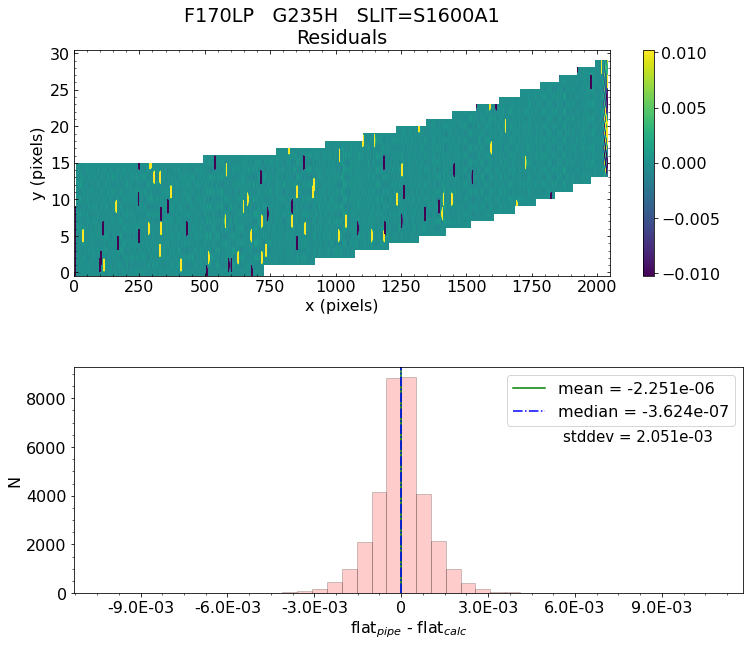


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_fs.py took ', '32.362651109695435 seconds to finish.')
Did flat_field for  bots_g235h_f170lp  validation test passed?  All slits PASSED flat_field test. 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/bots_g235h_f170lp_nrs2_interpolatedflat.fits', fd=66) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_dflat_nrs2_f_01.03.fits', fd=67) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs2_f_01.01.fits', fd=68) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/nirspec_FS_fflat_F170LP_01.01.fits', fd=69) 


Closing file:  popenfile(path='/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp_tuumxpz/bots_g235h_f170lp_nrs2_interpolatedfla

In [8]:
# Get the FS data for BOTS

for mode_config, data_set_dict in testing_data.items():
    if 'mos' in mode_config or 'ifu' in mode_config:
        continue
    if 'bots' not in mode_config:
        continue
        
    print('Starting to run pipeline and test for mode: ', mode_config)
    
    for detector in detectors:
        print('Testing files for detector: ', detector)
        data = get_artifactory_file(data_set_dict, detector)
        uncal_file, sflat, fflat, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        dflat = dflat_nrs1
        if '2' in detector:
            dflat = dflat_nrs2
        
        # Make sure these keywords are properly set
        filt = fits.getval(uncal_file, 'FILTER')
        if 'OPAQUE' in filt or 'allslits' in uncal_basename.lower():
            if 'clear' in uncal_basename.lower():
                filt = 'CLEAR'
            else:
                l = uncal_basename.split("_")
                for li in l:
                    if 'lp' in li.lower():
                        filt = li
                        break
            fits.setval(uncal_file, 'FILTER', value=filt)
        print('Filter = ', filt)
        if 'bots' in uncal_basename.lower():
            fits.setval(uncal_file, 'TSOVISIT', value=True)
            fits.setval(uncal_file, 'FXD_SLIT', value='S1600A1')
        elif 'fs' in uncal_basename.lower():
            fits.setval(uncal_file, 'FXD_SLIT', value='S200A1')

        # Run the stage 1 pipeline 
        print('Running the detector1 pipeline...')
        rate_object = Detector1Pipeline.call(uncal_file)
        
        # Make sure the FXD_SLIT keyword is set correctly
        try:
            if 'full' in rate_object.meta.instrument.fixed_slit:
                rate_object.meta.instrument.fixed_slit = 'NONE'
        except TypeError:
            print('FXD_SLIT keyword = ', rate_object.meta.instrument.fixed_slit)
        
        # Run the stage 2 pipeline steps
        print('\nRunning the spec2 pipeline...')
        skip_file = False
        try:
            #pipe_object = AssignWcsStep.call(rate_object)  # commenting indiv steps, using spec2 instead
            parameter_dict = {"flat_field": {"save_interpolated_flat": True},
                              "pathloss": {"skip": True},
                              "barshadow": {"skip": True},
                              "photom": {"skip": True},
                              "resample_spec": {"skip": True},
                              "cube_build": {"skip": True},
                              "extract_1d": {"skip": True}
                             }
            flat_field_object = Spec2Pipeline.call(rate_object, steps=parameter_dict)
        except:
            #print("No open slits fall on detector ", det)  # usually why assign_wcs crashes
            print("* Spec2 pipeline CRASHED or exited with no output for detector ", detector)
            print("  Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:   
            # accepted threshold difference with respect to benchmark files
            threshold_diff = 9.999e-5
            if 'prism' in uncal_basename.lower():
                threshold_diff = 9.999e-3
            
            # Run the validation test
            %matplotlib inline
            interpolated_flat = os.path.basename(uncal_file).replace('uncal', 'interpolatedflat')
            print('Running flat field test for BOTS...')
            result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(
                                                                            flat_field_object,
                                                                            dflat_path=dflat,
                                                                            sflat_path=sflat, 
                                                                            fflat_path=fflat,
                                                                            writefile=writefile,
                                                                            show_figs=show_figs, 
                                                                            save_figs=save_figs,
                                                                            interpolated_flat=interpolated_flat,
                                                                            threshold_diff=threshold_diff,
                                                                            debug=False)
        else:
            result, result_msg = 'skipped', 'skipped'

        # Did the test passed 
        print("Did flat_field for ", mode_config, " validation test passed? ", result_msg, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd, '\n\n')
                open(fd.fd).close()
            except:
                print('File already closed: ', fd, '\n\n')


In [9]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
bots_g235h_f170lp_nrs1_uncal.fits          PASSED  
bots_g235h_f170lp_nrs2_uncal.fits          PASSED  


/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/23/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 